# 1. Overview

The notebook details a process to select ASML suppliers by analyzing historical stock data for companies like: Carl Zeiss Meditec, Lam Research Corporation, and Tokyo Electron Limited. It involves retrieving stock data, plotting trends, checking for seasonality, and using Prophet models to forecast weekly closing prices. The forecasting models for each supplier were optimized through fine-tuning, and key metrics like MAPE and RMSE were calculated to assess accuracy. The final models were saved, along with the weekly supplier data, for future reference and further analysis.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Disable all logs from cmdstanpy by setting the logger to the ERROR level
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [2]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited',
    'TSM': 'Taiwan Semiconductor Manufacturing Company',
    '005930.KS': 'Samsung Electronics',
    'INTC': 'Intel Corporation'
}
start_date = '2013-01-01'
output_data = 'data/weekly_data_suppliers.csv'

test_weeks = 16

## 2.4 Functions

In [3]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [5]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [6]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [7]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...
Loading data for Taiwan Semiconductor Manufacturing Company...
Loading data for Samsung Electronics...
Loading data for Intel Corporation...


,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,Close_Taiwan Semiconductor Manufacturing Company,Close_Samsung Electronics,Close_Intel Corporation
Date,,,,,,
2013-01-02,25.741583,2.052361,7.846667,13.070150,24318.667969,15.289291
2013-01-03,25.741583,2.012616,7.766667,13.062925,23809.449219,15.246392
2013-01-04,25.961220,2.017385,7.700000,12.969047,23531.701172,15.131970
2013-01-07,25.961220,1.990891,7.613333,12.781303,23454.544922,15.196334
2013-01-08,25.961220,1.959625,7.366667,12.665765,23145.933594,15.081909


Now let's plot the stock data

****CARL ZEISS MEDITEC****



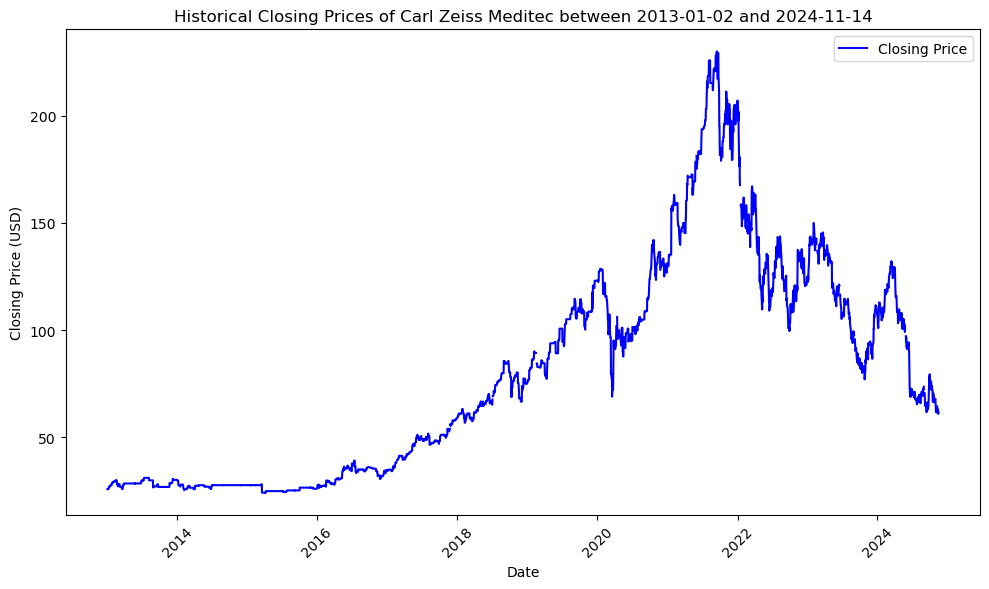


****LAM RESEARCH CORPORATION****



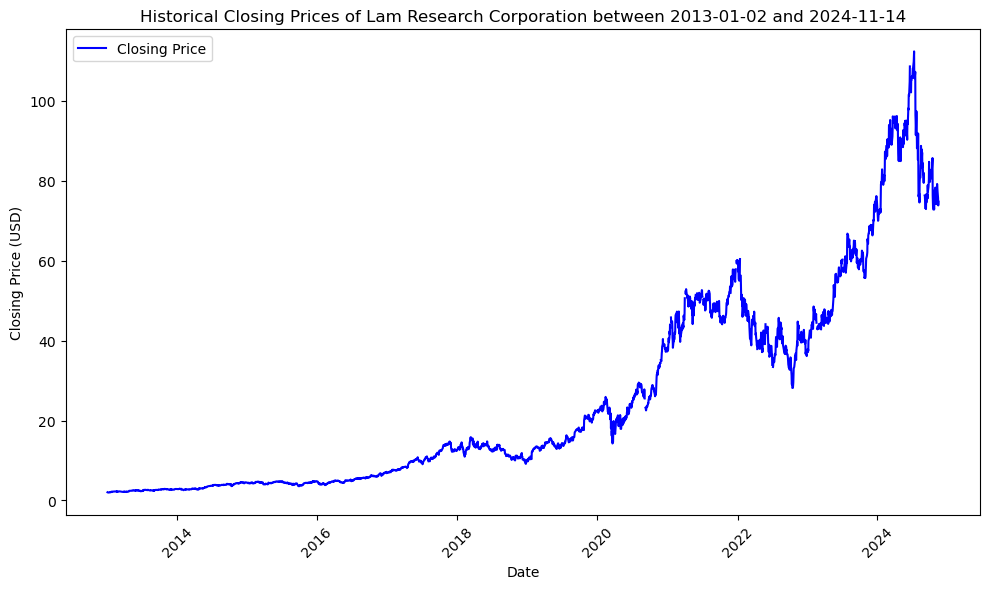


****TOKYO ELECTRON LIMITED****



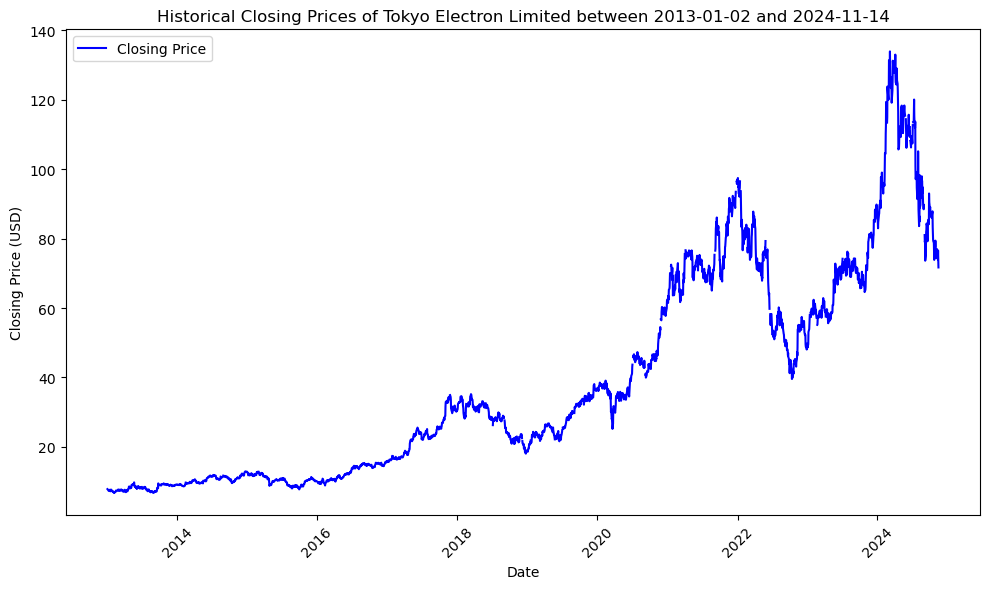


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



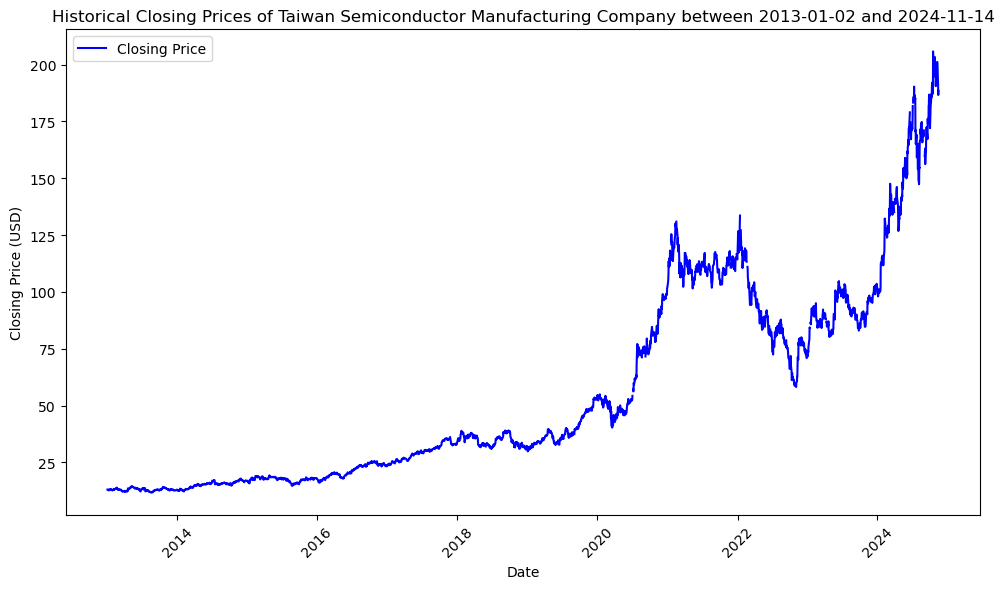


****SAMSUNG ELECTRONICS****



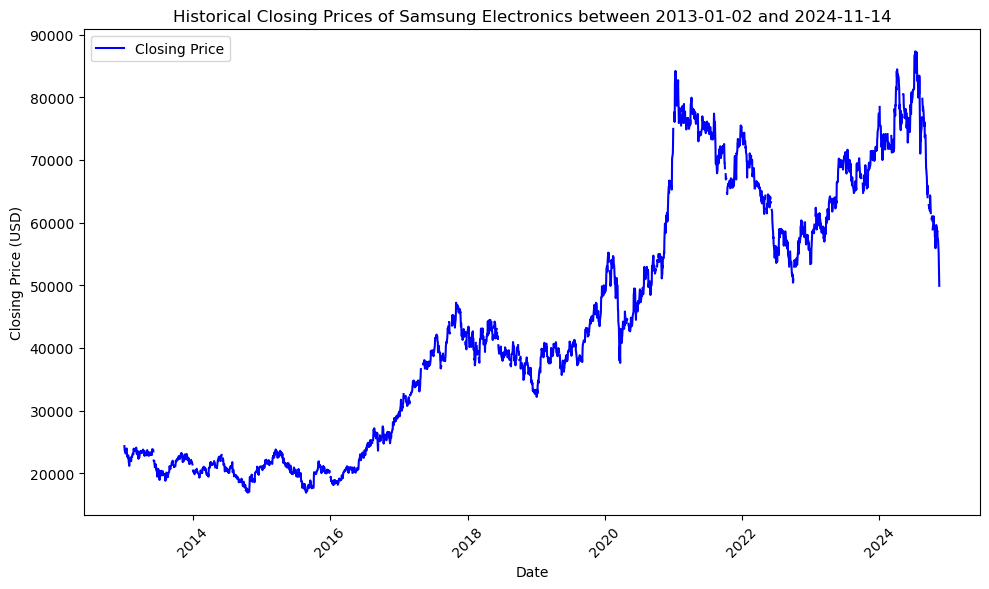


****INTEL CORPORATION****



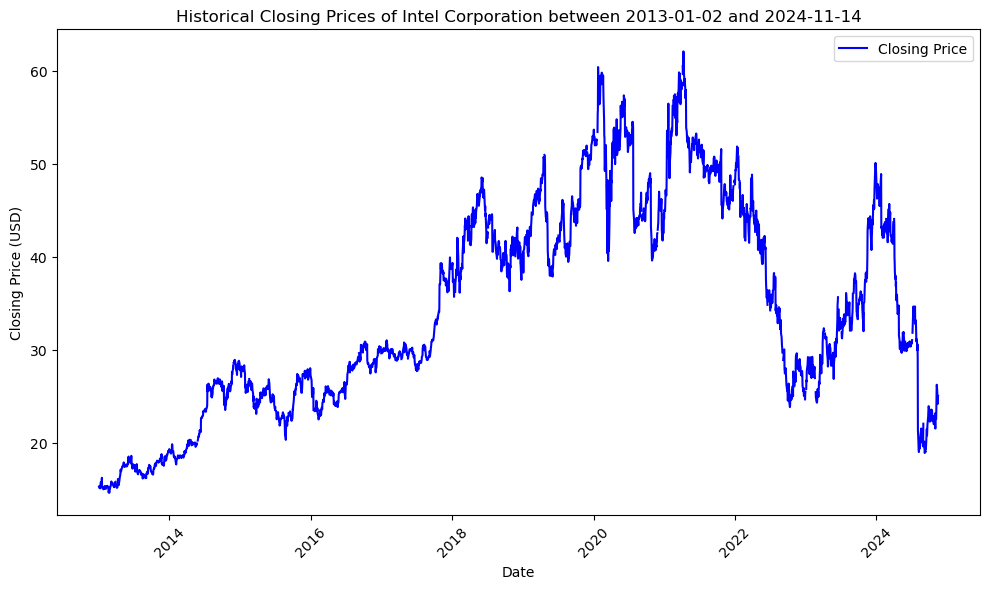

In [8]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [9]:
merged_data.duplicated().sum()

1

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [10]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec                            2.923027
Close_Lam Research Corporation                      2.923027
Close_Tokyo Electron Limited                        2.923027
Close_Taiwan Semiconductor Manufacturing Company    2.923027
Close_Samsung Electronics                           5.293927
Close_Intel Corporation                             2.923027
dtype: float64

As we can see there aren't any null values

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

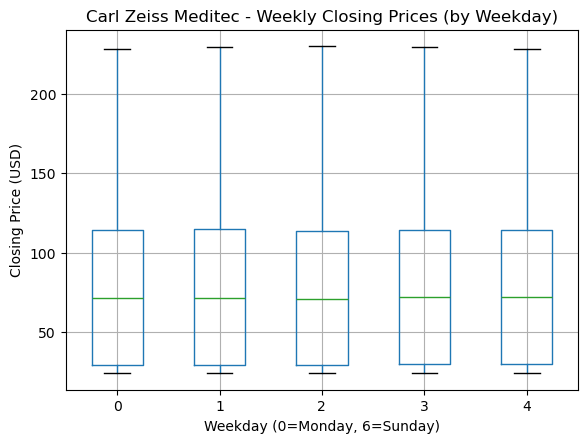

<Figure size 1200x800 with 0 Axes>

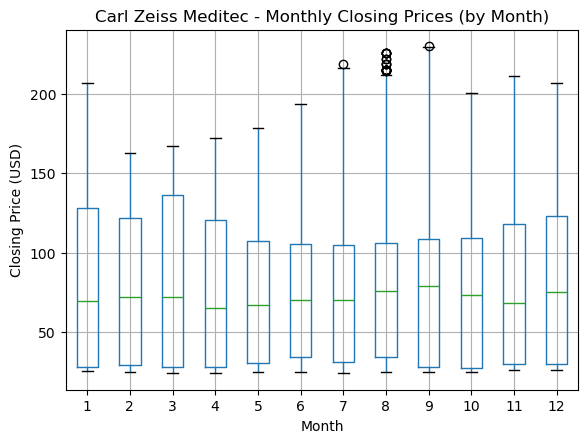

<Figure size 1200x800 with 0 Axes>

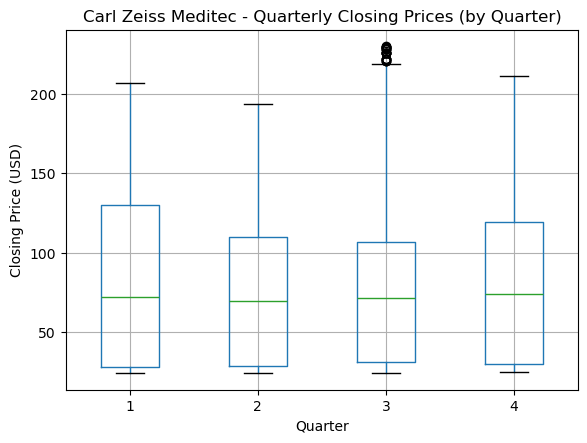


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

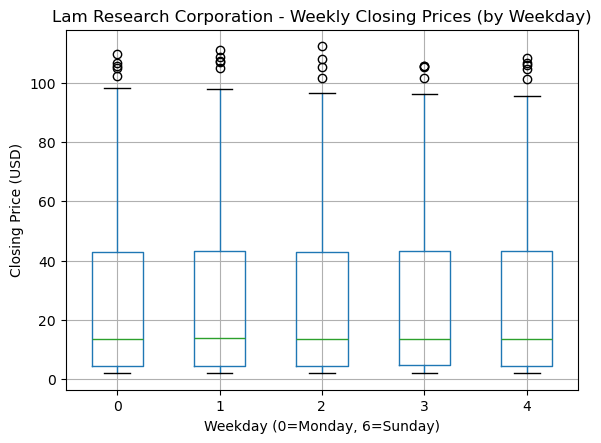

<Figure size 1200x800 with 0 Axes>

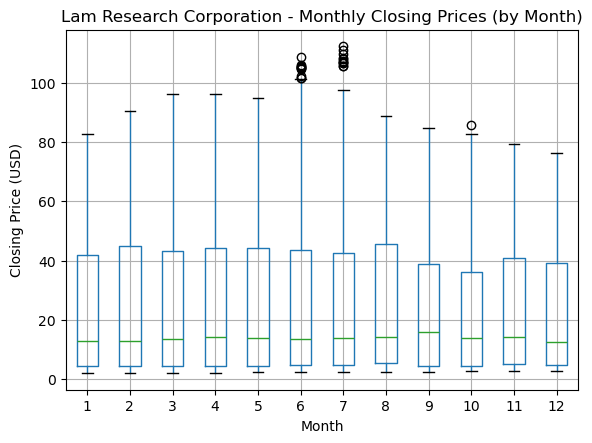

<Figure size 1200x800 with 0 Axes>

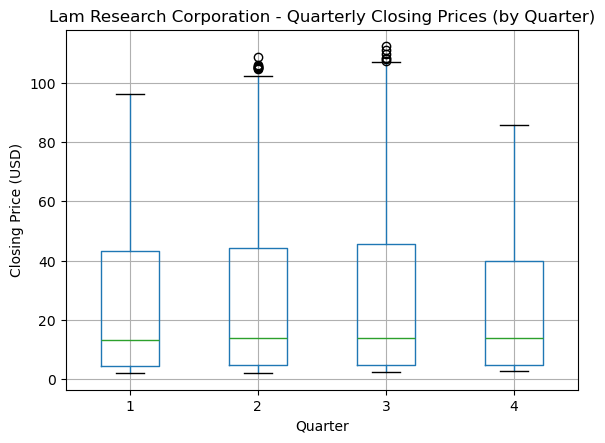


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

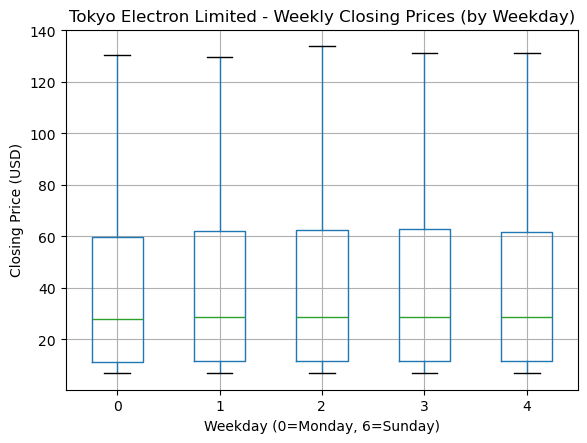

<Figure size 1200x800 with 0 Axes>

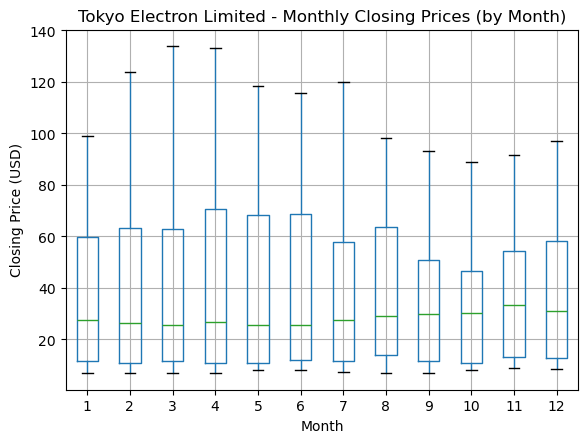

<Figure size 1200x800 with 0 Axes>

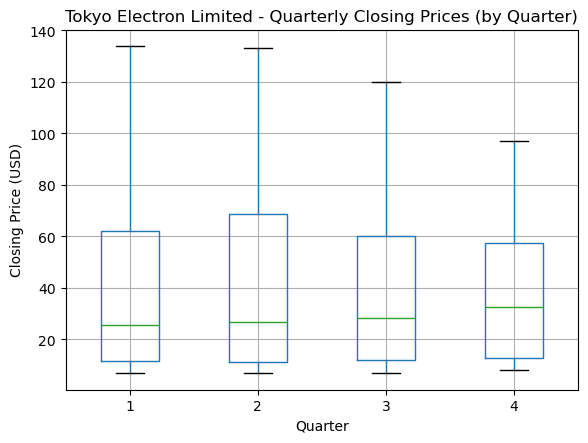


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



<Figure size 1200x800 with 0 Axes>

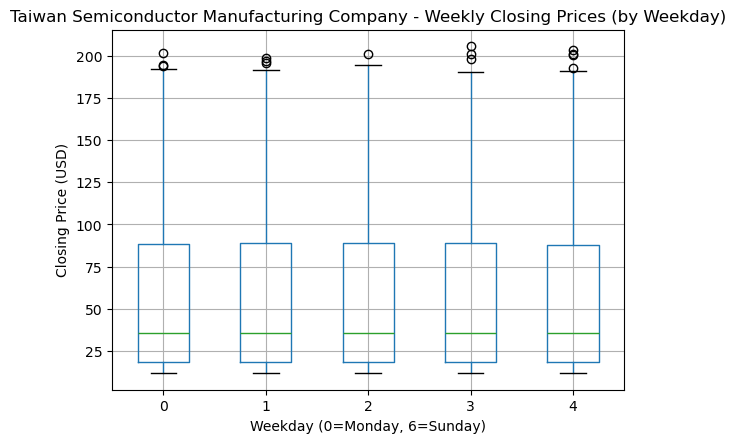

<Figure size 1200x800 with 0 Axes>

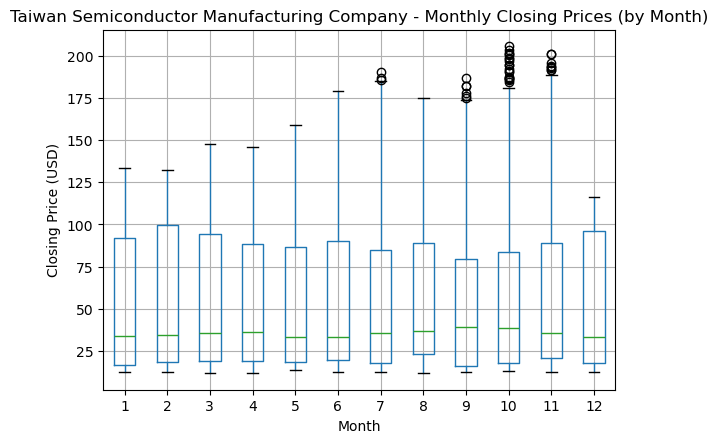

<Figure size 1200x800 with 0 Axes>

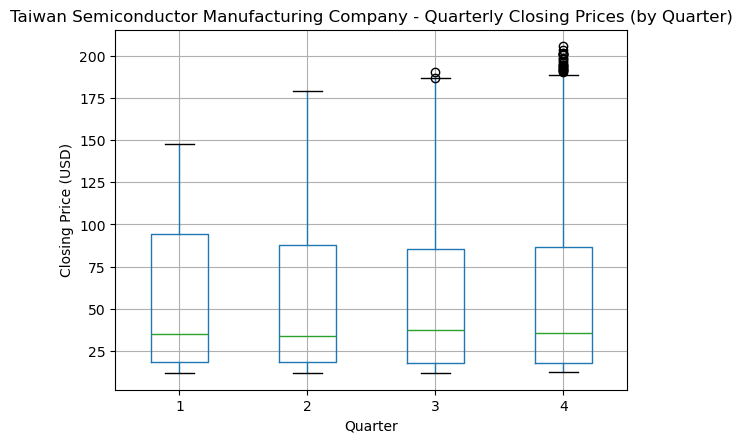


****SAMSUNG ELECTRONICS****



<Figure size 1200x800 with 0 Axes>

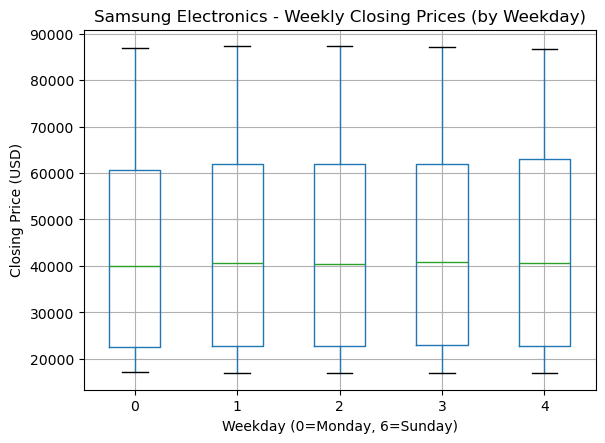

<Figure size 1200x800 with 0 Axes>

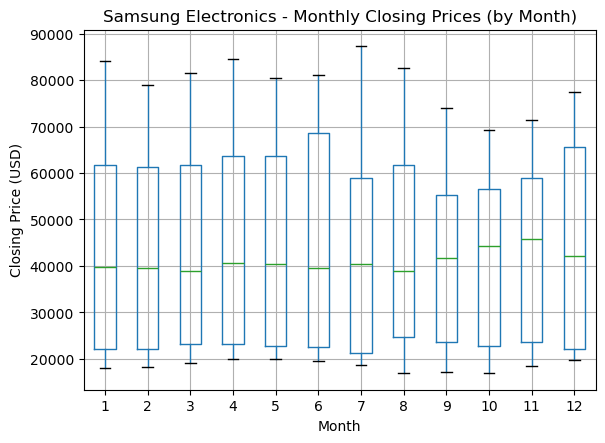

<Figure size 1200x800 with 0 Axes>

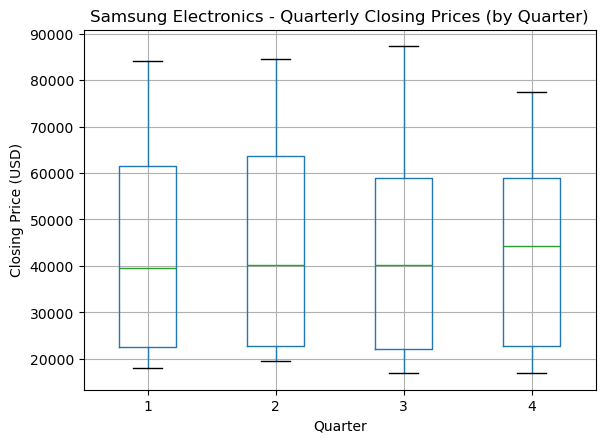


****INTEL CORPORATION****



<Figure size 1200x800 with 0 Axes>

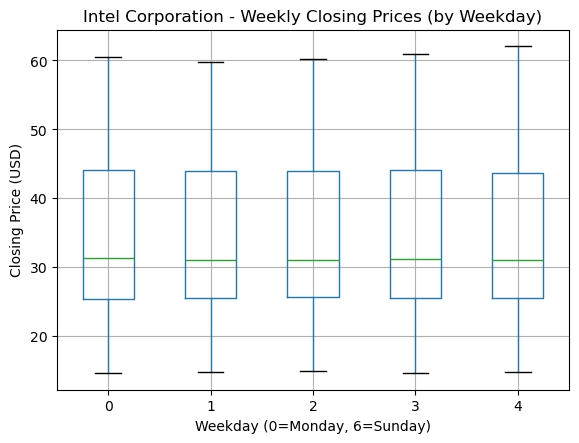

<Figure size 1200x800 with 0 Axes>

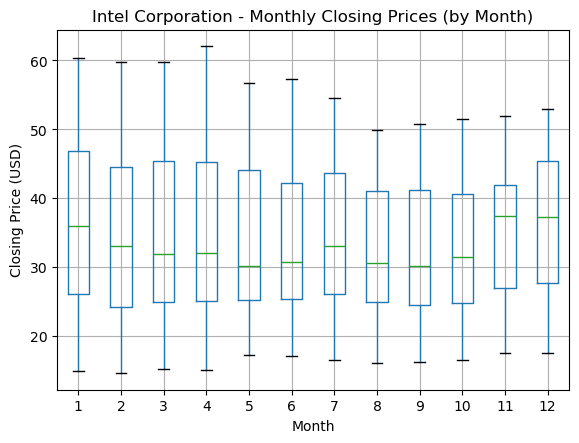

<Figure size 1200x800 with 0 Axes>

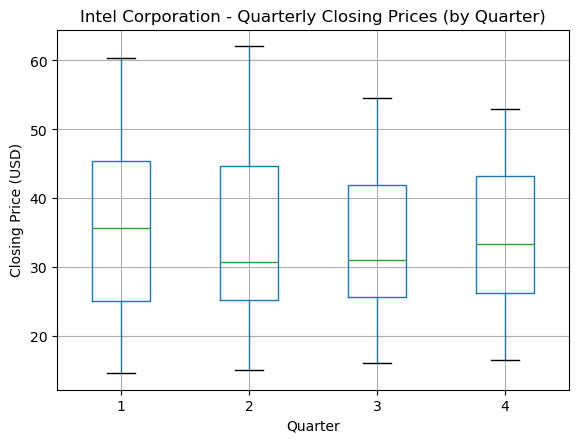

In [11]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [12]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,Close_Taiwan Semiconductor Manufacturing Company,Close_Samsung Electronics,Close_Intel Corporation,Date,Weekday,Month,Quarter
Date,,,,,,,,,,
2013-01-06,25.741583,2.017385,7.766667,13.062925,23809.449219,15.246392,2013-01-03,3.0,1.0,1.0
2013-01-13,26.057865,1.990891,7.480000,12.781303,23454.544922,15.339357,2013-01-09,2.0,1.0,1.0
2013-01-20,27.226334,2.030634,7.460000,13.005154,23022.486328,15.732670,2013-01-16,2.0,1.0,1.0
2013-01-27,27.674398,2.124429,7.406667,12.987102,22436.128906,15.042583,2013-01-23,2.0,1.0,1.0
2013-02-03,28.728655,2.210805,7.140000,12.824625,22220.103516,15.217786,2013-01-30,2.0,1.0,1.0


### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [13]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [14]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl Zeiss Meditec'].head()

,Close
Date,
2013-01-06,25.741583
2013-01-13,26.057865
2013-01-20,27.226334
2013-01-27,27.674398
2013-02-03,28.728655


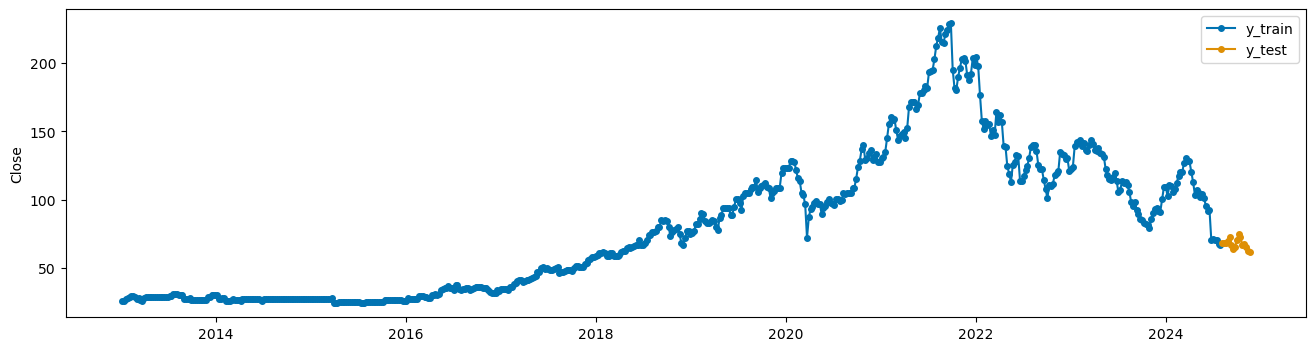

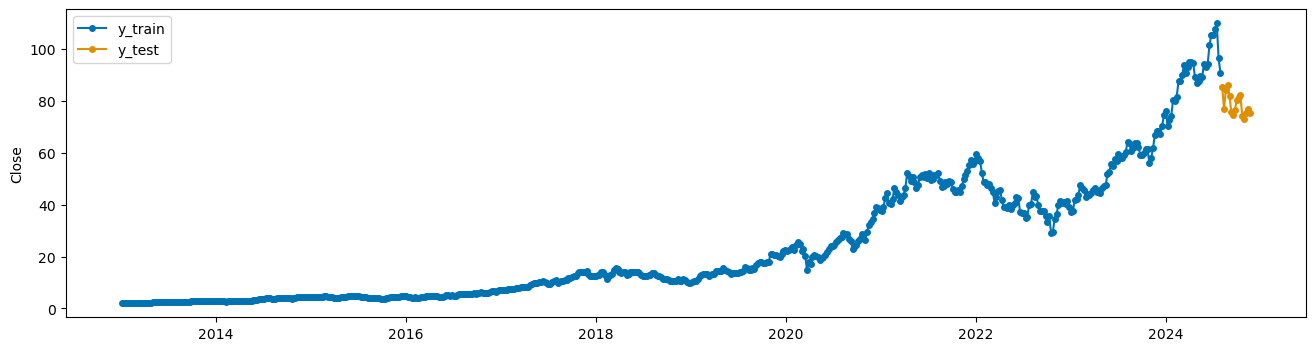

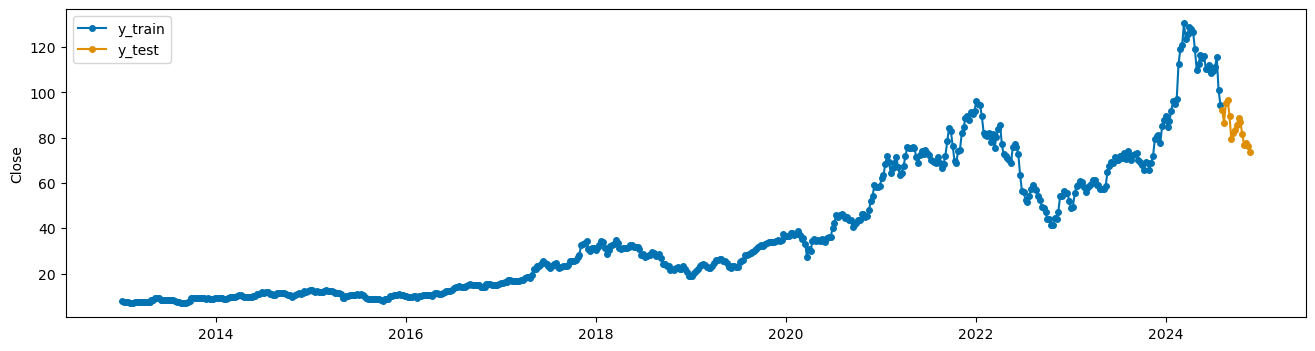

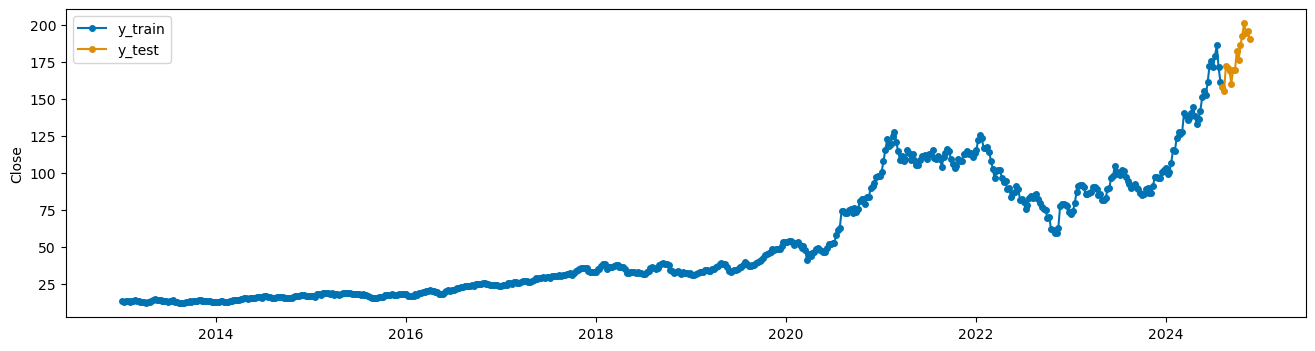

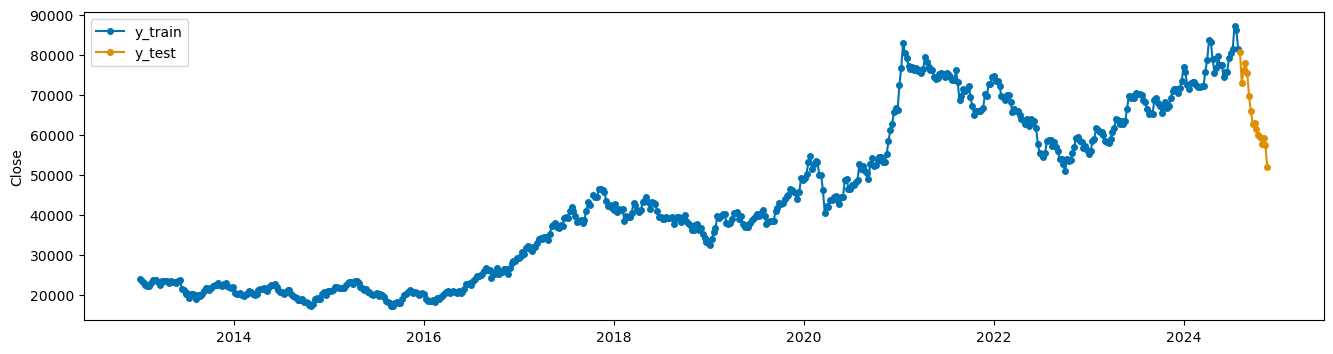

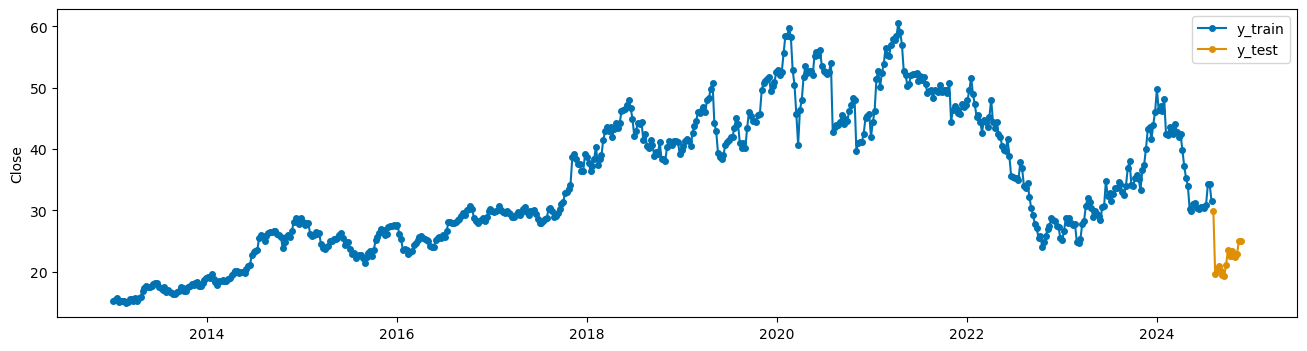

In [15]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

17:16:02 - cmdstanpy - INFO - Chain [1] start processing
17:16:02 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Carl Zeiss Meditec
MAPE: 13.86
RMSE: 10.44


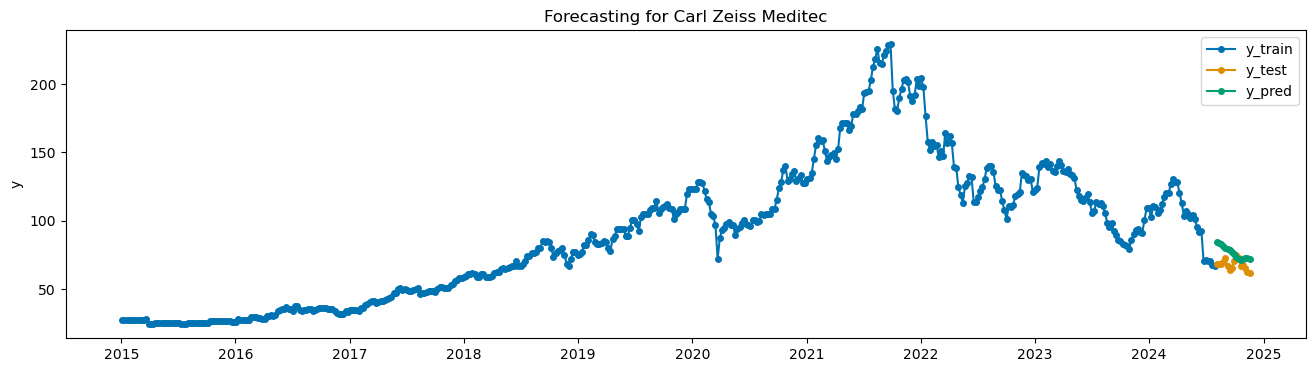

17:16:02 - cmdstanpy - INFO - Chain [1] start processing
17:16:03 - cmdstanpy - INFO - Chain [1] done processing
17:16:03 - cmdstanpy - INFO - Chain [1] start processing
17:16:03 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Lam Research Corporation
MAPE: 8.08
RMSE: 7.28


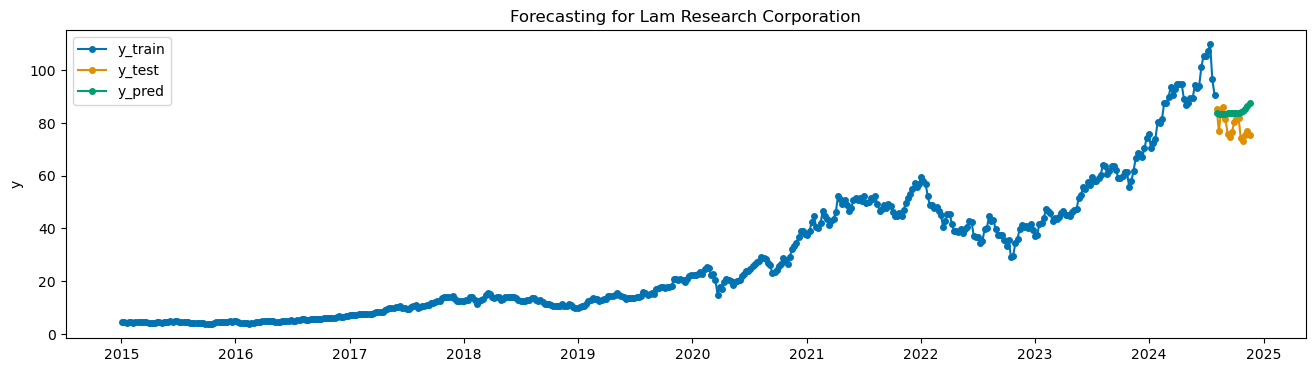

17:16:03 - cmdstanpy - INFO - Chain [1] start processing
17:16:03 - cmdstanpy - INFO - Chain [1] done processing
17:16:03 - cmdstanpy - INFO - Chain [1] start processing
17:16:04 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Tokyo Electron Limited
MAPE: 11.54
RMSE: 11.18


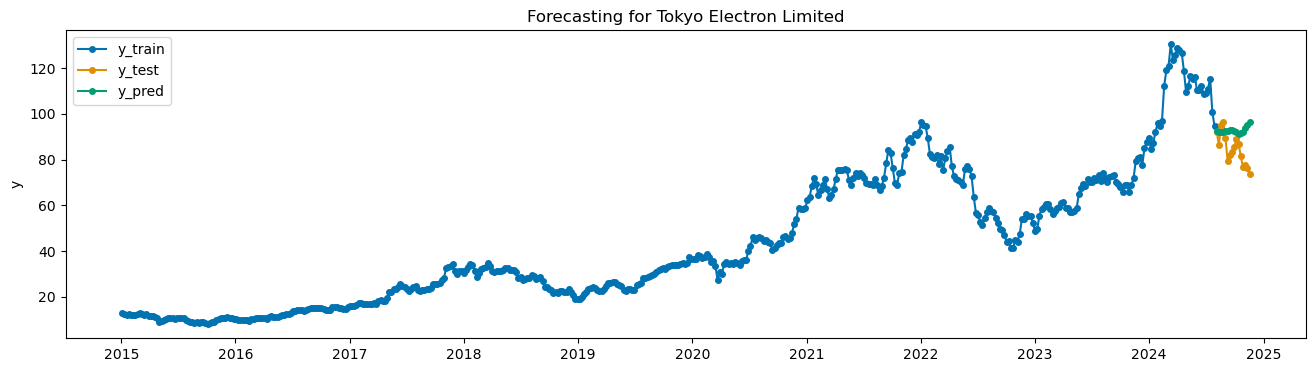

17:16:04 - cmdstanpy - INFO - Chain [1] start processing
17:16:04 - cmdstanpy - INFO - Chain [1] done processing
17:16:04 - cmdstanpy - INFO - Chain [1] start processing
17:16:04 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Taiwan Semiconductor Manufacturing Company
MAPE: 34.31
RMSE: 63.26


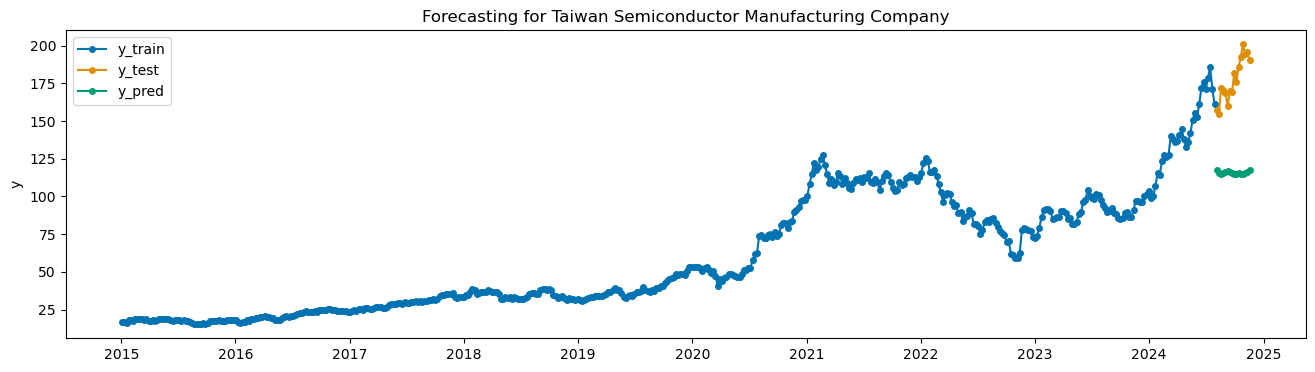

17:16:05 - cmdstanpy - INFO - Chain [1] start processing
17:16:05 - cmdstanpy - INFO - Chain [1] done processing
17:16:05 - cmdstanpy - INFO - Chain [1] start processing
17:16:05 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Samsung Electronics
MAPE: 13.98
RMSE: 9731.59


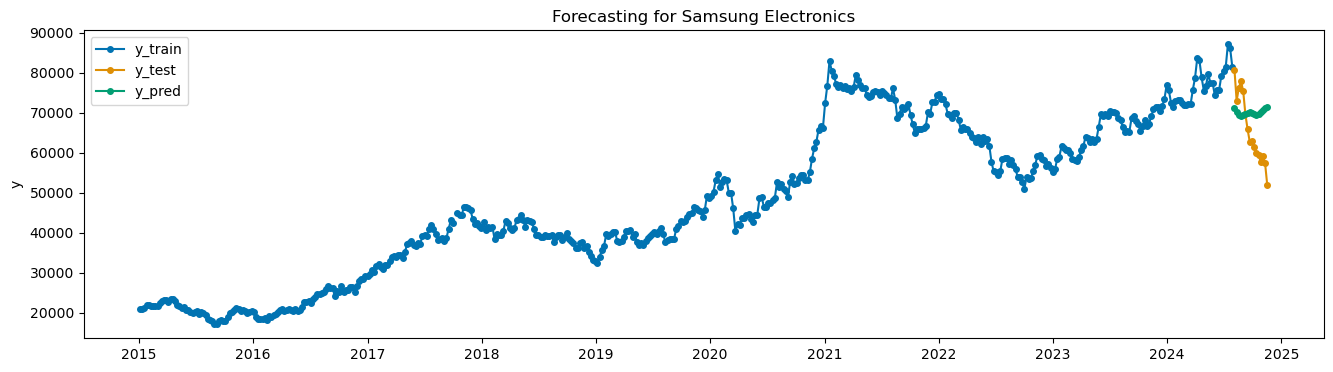

17:16:06 - cmdstanpy - INFO - Chain [1] start processing
17:16:06 - cmdstanpy - INFO - Chain [1] done processing
17:16:06 - cmdstanpy - INFO - Chain [1] start processing
17:16:06 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Intel Corporation
MAPE: 27.47
RMSE: 6.28


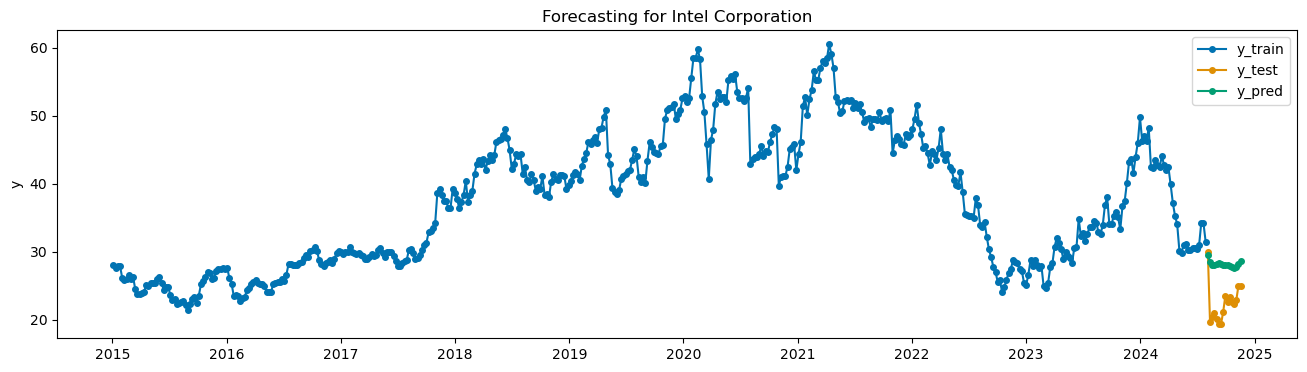

17:16:06 - cmdstanpy - INFO - Chain [1] start processing
17:16:06 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company
    
    # We need are now going to save the prophet_models only that this time, we will fit it with all the data (train and test data) 
    # Initialize the Prophet model
    prophet_model = Prophet()
    # We have modified the data to be able to train the prophet model
    test_data = pd.DataFrame(actuals).rename(columns={'Close':'y'}).reset_index(names="ds")
    train_data_prophet = train_data_prophet.reset_index(names="ds")
    all_data = pd.concat([train_data_prophet,test_data])
    prophet_model.fit(all_data)
    
    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model



#### 2.5.6.3 Fine-tunning the prophet models

We have commented the code below as the fine tunning takes approximately 3 hrs to run

In [17]:
# pip install optuna


In [18]:
import optuna
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# Diccionario para almacenar los mejores parámetros y MAPE de cada empresa
best_params_per_company = {}
final_mape_per_company = {}
n_trials = 50  # Número total de combinaciones a probar

# Función objetivo para Optuna
def objective(trial, train_data_prophet, test_data, company_name):
    # Contador de la combinación actual
    current_trial = trial.number + 1
    print(f"{company_name} - Trial {current_trial}/{n_trials}: Optimizing...")

    # Sugerencia de parámetros con los nuevos rangos
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 10)

    # Crear y ajustar el modelo Prophet con los parámetros sugeridos
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(train_data_prophet)

    # Hacer predicciones
    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Calcular MAPE entre los datos de prueba y las predicciones
    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

    # Imprimir el progreso
    print(f"{company_name} - Completed Trial {current_trial}/{n_trials}. Remaining: {n_trials - current_trial} trials.")

    return mape

# Bucle para cada empresa en company_tickers
for company in company_tickers.values():
    print(f"Optimizing for {company}...")

    # Preparar los datos de entrenamiento y prueba para Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Asegurarse de que el índice sea de tipo datetime
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Crear un estudio de Optuna y optimizar
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, train_data_prophet, test_data, company), n_trials=n_trials)

    # Guardar los mejores parámetros para la empresa actual
    best_params_per_company[company] = study.best_params

    # Ajustar el modelo con los mejores parámetros para calcular el MAPE final
    model = Prophet(
        changepoint_prior_scale=study.best_params['changepoint_prior_scale'],
        seasonality_prior_scale=study.best_params['seasonality_prior_scale']
    )
    model.fit(train_data_prophet)

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    final_mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

    # Guardar el MAPE final para la empresa
    final_mape_per_company[company] = final_mape

# Imprimir los mejores parámetros y el MAPE final de todas las empresas al final
print("\nFinal results for each company:")
for company in company_tickers.values():
    print(f"{company}: Best parameters: {best_params_per_company[company]}, Final MAPE: {final_mape_per_company[company]:.2f}")

# Crear un diccionario con los mejores parámetros para cada empresa usando company_tickers
company_params = {
    ticker: {
        'changepoint_prior_scale': round(best_params_per_company[company]['changepoint_prior_scale'], 4),
        'seasonality_prior_scale': round(best_params_per_company[company]['seasonality_prior_scale'], 4)
    }
    for ticker, company in company_tickers.items()
}


[I 2024-11-15 17:16:07,046] A new study created in memory with name: no-name-fb6ab428-2063-4c4f-9e07-d8b6cd7870cc
17:16:07 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Carl Zeiss Meditec...
Carl Zeiss Meditec - Trial 1/50: Optimizing...


17:16:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:07,467] Trial 0 finished with value: 27.24039832310648 and parameters: {'changepoint_prior_scale': 0.23029567302187723, 'seasonality_prior_scale': 4.536167579698019}. Best is trial 0 with value: 27.24039832310648.
17:16:07 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 1/50. Remaining: 49 trials.
Carl Zeiss Meditec - Trial 2/50: Optimizing...


17:16:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:07,822] Trial 1 finished with value: 19.95703515947976 and parameters: {'changepoint_prior_scale': 0.11411807409472743, 'seasonality_prior_scale': 5.685951329903474}. Best is trial 1 with value: 19.95703515947976.
17:16:07 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 2/50. Remaining: 48 trials.
Carl Zeiss Meditec - Trial 3/50: Optimizing...


17:16:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:08,243] Trial 2 finished with value: 28.16048296585062 and parameters: {'changepoint_prior_scale': 0.2707860493996823, 'seasonality_prior_scale': 7.470745350823157}. Best is trial 1 with value: 19.95703515947976.
17:16:08 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 3/50. Remaining: 47 trials.
Carl Zeiss Meditec - Trial 4/50: Optimizing...


17:16:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:08,641] Trial 3 finished with value: 21.181495486181262 and parameters: {'changepoint_prior_scale': 0.11273550191021944, 'seasonality_prior_scale': 4.713180756095007}. Best is trial 1 with value: 19.95703515947976.
17:16:08 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 4/50. Remaining: 46 trials.
Carl Zeiss Meditec - Trial 5/50: Optimizing...


17:16:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:09,121] Trial 4 finished with value: 28.536456643944536 and parameters: {'changepoint_prior_scale': 0.34773879578161, 'seasonality_prior_scale': 7.542546000298633}. Best is trial 1 with value: 19.95703515947976.
17:16:09 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 5/50. Remaining: 45 trials.
Carl Zeiss Meditec - Trial 6/50: Optimizing...


17:16:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:09,496] Trial 5 finished with value: 21.300235665049595 and parameters: {'changepoint_prior_scale': 0.03164084996484878, 'seasonality_prior_scale': 7.72451609642202}. Best is trial 1 with value: 19.95703515947976.
17:16:09 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 6/50. Remaining: 44 trials.
Carl Zeiss Meditec - Trial 7/50: Optimizing...


17:16:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:09,979] Trial 6 finished with value: 28.545479582025123 and parameters: {'changepoint_prior_scale': 0.33147056778765643, 'seasonality_prior_scale': 9.24991918032008}. Best is trial 1 with value: 19.95703515947976.
17:16:10 - cmdstanpy - INFO - Chain [1] start processing
17:16:10 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 7/50. Remaining: 43 trials.
Carl Zeiss Meditec - Trial 8/50: Optimizing...


[I 2024-11-15 17:16:10,288] Trial 7 finished with value: 32.8717939329492 and parameters: {'changepoint_prior_scale': 0.018393863039293506, 'seasonality_prior_scale': 0.21291162013168421}. Best is trial 1 with value: 19.95703515947976.
17:16:10 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 8/50. Remaining: 42 trials.
Carl Zeiss Meditec - Trial 9/50: Optimizing...


17:16:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:10,674] Trial 8 finished with value: 20.795615935624195 and parameters: {'changepoint_prior_scale': 0.11588788050914846, 'seasonality_prior_scale': 6.509793446807097}. Best is trial 1 with value: 19.95703515947976.
17:16:10 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 9/50. Remaining: 41 trials.
Carl Zeiss Meditec - Trial 10/50: Optimizing...


17:16:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:11,122] Trial 9 finished with value: 25.911256092232236 and parameters: {'changepoint_prior_scale': 0.17045893267617146, 'seasonality_prior_scale': 1.3214472410309333}. Best is trial 1 with value: 19.95703515947976.
17:16:11 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 10/50. Remaining: 40 trials.
Carl Zeiss Meditec - Trial 11/50: Optimizing...


17:16:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:11,620] Trial 10 finished with value: 28.767043970407315 and parameters: {'changepoint_prior_scale': 0.47893837438959297, 'seasonality_prior_scale': 3.1367672649983556}. Best is trial 1 with value: 19.95703515947976.
17:16:11 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 11/50. Remaining: 39 trials.
Carl Zeiss Meditec - Trial 12/50: Optimizing...


17:16:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:12,075] Trial 11 finished with value: 20.62233592851844 and parameters: {'changepoint_prior_scale': 0.10982566786881803, 'seasonality_prior_scale': 6.070027048023794}. Best is trial 1 with value: 19.95703515947976.
17:16:12 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 12/50. Remaining: 38 trials.
Carl Zeiss Meditec - Trial 13/50: Optimizing...


17:16:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:12,483] Trial 12 finished with value: 19.246942025677306 and parameters: {'changepoint_prior_scale': 0.10754105721649301, 'seasonality_prior_scale': 5.697894629403455}. Best is trial 12 with value: 19.246942025677306.
17:16:12 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 13/50. Remaining: 37 trials.
Carl Zeiss Meditec - Trial 14/50: Optimizing...


17:16:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:12,933] Trial 13 finished with value: 27.354540156804852 and parameters: {'changepoint_prior_scale': 0.2181962089827169, 'seasonality_prior_scale': 3.1528465417004554}. Best is trial 12 with value: 19.246942025677306.
17:16:13 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 14/50. Remaining: 36 trials.
Carl Zeiss Meditec - Trial 15/50: Optimizing...


17:16:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:13,414] Trial 14 finished with value: 13.645594243973736 and parameters: {'changepoint_prior_scale': 0.07783101810575113, 'seasonality_prior_scale': 9.478556282970303}. Best is trial 14 with value: 13.645594243973736.
17:16:13 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 15/50. Remaining: 35 trials.
Carl Zeiss Meditec - Trial 16/50: Optimizing...


17:16:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:13,751] Trial 15 finished with value: 13.986594644295733 and parameters: {'changepoint_prior_scale': 0.04878321222735121, 'seasonality_prior_scale': 9.776970889870995}. Best is trial 14 with value: 13.645594243973736.
17:16:13 - cmdstanpy - INFO - Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 16/50. Remaining: 34 trials.
Carl Zeiss Meditec - Trial 17/50: Optimizing...


[I 2024-11-15 17:16:14,045] Trial 16 finished with value: 127.3714048585588 and parameters: {'changepoint_prior_scale': 0.006055828280099526, 'seasonality_prior_scale': 9.327558894692604}. Best is trial 14 with value: 13.645594243973736.
17:16:14 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 17/50. Remaining: 33 trials.
Carl Zeiss Meditec - Trial 18/50: Optimizing...


17:16:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:14,396] Trial 17 finished with value: 13.168381820455405 and parameters: {'changepoint_prior_scale': 0.05876800872885151, 'seasonality_prior_scale': 9.94427295898894}. Best is trial 17 with value: 13.168381820455405.
17:16:14 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 18/50. Remaining: 32 trials.
Carl Zeiss Meditec - Trial 19/50: Optimizing...


17:16:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:14,868] Trial 18 finished with value: 26.537725716035922 and parameters: {'changepoint_prior_scale': 0.17938242942789923, 'seasonality_prior_scale': 8.578545387009875}. Best is trial 17 with value: 13.168381820455405.
17:16:14 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 19/50. Remaining: 31 trials.
Carl Zeiss Meditec - Trial 20/50: Optimizing...


17:16:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:15,402] Trial 19 finished with value: 28.828878108341844 and parameters: {'changepoint_prior_scale': 0.4694082606940606, 'seasonality_prior_scale': 8.486769558425275}. Best is trial 17 with value: 13.168381820455405.
17:16:15 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 20/50. Remaining: 30 trials.
Carl Zeiss Meditec - Trial 21/50: Optimizing...


17:16:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:16,073] Trial 20 finished with value: 28.509634608993316 and parameters: {'changepoint_prior_scale': 0.2914952443925916, 'seasonality_prior_scale': 9.789400867724714}. Best is trial 17 with value: 13.168381820455405.
17:16:16 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 21/50. Remaining: 29 trials.
Carl Zeiss Meditec - Trial 22/50: Optimizing...


17:16:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:16,467] Trial 21 finished with value: 12.159794315477178 and parameters: {'changepoint_prior_scale': 0.06841041607888904, 'seasonality_prior_scale': 9.87223689649431}. Best is trial 21 with value: 12.159794315477178.
17:16:16 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 22/50. Remaining: 28 trials.
Carl Zeiss Meditec - Trial 23/50: Optimizing...


17:16:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:16,860] Trial 22 finished with value: 12.064835593144114 and parameters: {'changepoint_prior_scale': 0.06357757651231193, 'seasonality_prior_scale': 8.512381152825267}. Best is trial 22 with value: 12.064835593144114.
17:16:16 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 23/50. Remaining: 27 trials.
Carl Zeiss Meditec - Trial 24/50: Optimizing...


17:16:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:17,318] Trial 23 finished with value: 25.4369771004753 and parameters: {'changepoint_prior_scale': 0.15654334082077973, 'seasonality_prior_scale': 8.405907280869382}. Best is trial 22 with value: 12.064835593144114.
17:16:17 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 24/50. Remaining: 26 trials.
Carl Zeiss Meditec - Trial 25/50: Optimizing...


17:16:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:17,924] Trial 24 finished with value: 13.39220497018292 and parameters: {'changepoint_prior_scale': 0.05659260560293474, 'seasonality_prior_scale': 7.141032893667717}. Best is trial 22 with value: 12.064835593144114.


Carl Zeiss Meditec - Completed Trial 25/50. Remaining: 25 trials.
Carl Zeiss Meditec - Trial 26/50: Optimizing...


17:16:18 - cmdstanpy - INFO - Chain [1] start processing
17:16:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:18,574] Trial 25 finished with value: 12.037921597506468 and parameters: {'changepoint_prior_scale': 0.07013144819434673, 'seasonality_prior_scale': 8.878765335998397}. Best is trial 25 with value: 12.037921597506468.
17:16:18 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 26/50. Remaining: 24 trials.
Carl Zeiss Meditec - Trial 27/50: Optimizing...


17:16:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:19,243] Trial 26 finished with value: 28.66172298329024 and parameters: {'changepoint_prior_scale': 0.4122660677170635, 'seasonality_prior_scale': 8.541707305057205}. Best is trial 25 with value: 12.037921597506468.
17:16:19 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 27/50. Remaining: 23 trials.
Carl Zeiss Meditec - Trial 28/50: Optimizing...


17:16:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:19,835] Trial 27 finished with value: 24.855068131522845 and parameters: {'changepoint_prior_scale': 0.14419651930252567, 'seasonality_prior_scale': 8.091137428658925}. Best is trial 25 with value: 12.037921597506468.
17:16:20 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 28/50. Remaining: 22 trials.
Carl Zeiss Meditec - Trial 29/50: Optimizing...


17:16:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:20,546] Trial 28 finished with value: 26.866588047546013 and parameters: {'changepoint_prior_scale': 0.20038357773709184, 'seasonality_prior_scale': 7.028641789729389}. Best is trial 25 with value: 12.037921597506468.
17:16:20 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 29/50. Remaining: 21 trials.
Carl Zeiss Meditec - Trial 30/50: Optimizing...


17:16:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:21,027] Trial 29 finished with value: 13.094446901237081 and parameters: {'changepoint_prior_scale': 0.07727740281674361, 'seasonality_prior_scale': 4.1164944008540685}. Best is trial 25 with value: 12.037921597506468.
17:16:21 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 30/50. Remaining: 20 trials.
Carl Zeiss Meditec - Trial 31/50: Optimizing...


17:16:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:21,563] Trial 30 finished with value: 27.479962923167722 and parameters: {'changepoint_prior_scale': 0.23303683507487327, 'seasonality_prior_scale': 9.110219671962712}. Best is trial 25 with value: 12.037921597506468.
17:16:21 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 31/50. Remaining: 19 trials.
Carl Zeiss Meditec - Trial 32/50: Optimizing...


17:16:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:22,023] Trial 31 finished with value: 13.665245400218378 and parameters: {'changepoint_prior_scale': 0.07708452922471426, 'seasonality_prior_scale': 3.409362676526701}. Best is trial 25 with value: 12.037921597506468.
17:16:22 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 32/50. Remaining: 18 trials.
Carl Zeiss Meditec - Trial 33/50: Optimizing...


17:16:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:22,467] Trial 32 finished with value: 14.055051784375411 and parameters: {'changepoint_prior_scale': 0.0827020613025256, 'seasonality_prior_scale': 3.569518187827352}. Best is trial 25 with value: 12.037921597506468.
17:16:22 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 33/50. Remaining: 17 trials.
Carl Zeiss Meditec - Trial 34/50: Optimizing...


17:16:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:22,901] Trial 33 finished with value: 24.087788053677585 and parameters: {'changepoint_prior_scale': 0.13027864150274557, 'seasonality_prior_scale': 4.419962911758655}. Best is trial 25 with value: 12.037921597506468.


Carl Zeiss Meditec - Completed Trial 34/50. Remaining: 16 trials.
Carl Zeiss Meditec - Trial 35/50: Optimizing...


17:16:23 - cmdstanpy - INFO - Chain [1] start processing
17:16:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:23,284] Trial 34 finished with value: 124.26003064333568 and parameters: {'changepoint_prior_scale': 0.0045720295759879084, 'seasonality_prior_scale': 5.143410135054641}. Best is trial 25 with value: 12.037921597506468.
17:16:23 - cmdstanpy - INFO - Chain [1] start processing
17:16:23 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 35/50. Remaining: 15 trials.
Carl Zeiss Meditec - Trial 36/50: Optimizing...


[I 2024-11-15 17:16:23,609] Trial 35 finished with value: 18.067367132396008 and parameters: {'changepoint_prior_scale': 0.0386727362201013, 'seasonality_prior_scale': 2.0623363179374765}. Best is trial 25 with value: 12.037921597506468.
17:16:23 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 36/50. Remaining: 14 trials.
Carl Zeiss Meditec - Trial 37/50: Optimizing...


17:16:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:24,009] Trial 36 finished with value: 14.247576480809936 and parameters: {'changepoint_prior_scale': 0.08614791996488394, 'seasonality_prior_scale': 4.303368120992956}. Best is trial 25 with value: 12.037921597506468.
17:16:24 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 37/50. Remaining: 13 trials.
Carl Zeiss Meditec - Trial 38/50: Optimizing...


17:16:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:24,567] Trial 37 finished with value: 24.43678865615015 and parameters: {'changepoint_prior_scale': 0.1407245013623254, 'seasonality_prior_scale': 8.906398159523146}. Best is trial 25 with value: 12.037921597506468.
17:16:24 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 38/50. Remaining: 12 trials.
Carl Zeiss Meditec - Trial 39/50: Optimizing...


17:16:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:25,105] Trial 38 finished with value: 28.42756867934007 and parameters: {'changepoint_prior_scale': 0.2726231262415883, 'seasonality_prior_scale': 8.057982031008859}. Best is trial 25 with value: 12.037921597506468.
17:16:25 - cmdstanpy - INFO - Chain [1] start processing
17:16:25 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 39/50. Remaining: 11 trials.
Carl Zeiss Meditec - Trial 40/50: Optimizing...


[I 2024-11-15 17:16:25,424] Trial 39 finished with value: 21.45507460445792 and parameters: {'changepoint_prior_scale': 0.02961614857932121, 'seasonality_prior_scale': 6.2454787720276705}. Best is trial 25 with value: 12.037921597506468.
17:16:25 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 40/50. Remaining: 10 trials.
Carl Zeiss Meditec - Trial 41/50: Optimizing...


17:16:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:25,824] Trial 40 finished with value: 16.770027731385596 and parameters: {'changepoint_prior_scale': 0.09462704977482601, 'seasonality_prior_scale': 6.855735804827157}. Best is trial 25 with value: 12.037921597506468.
17:16:25 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 41/50. Remaining: 9 trials.
Carl Zeiss Meditec - Trial 42/50: Optimizing...


17:16:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:26,256] Trial 41 finished with value: 13.193474376499918 and parameters: {'changepoint_prior_scale': 0.05735737610932386, 'seasonality_prior_scale': 9.768611225431895}. Best is trial 25 with value: 12.037921597506468.
17:16:26 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 42/50. Remaining: 8 trials.
Carl Zeiss Meditec - Trial 43/50: Optimizing...


17:16:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:26,629] Trial 42 finished with value: 13.938460863800284 and parameters: {'changepoint_prior_scale': 0.04993725963975164, 'seasonality_prior_scale': 7.759666463604654}. Best is trial 25 with value: 12.037921597506468.
17:16:26 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 43/50. Remaining: 7 trials.
Carl Zeiss Meditec - Trial 44/50: Optimizing...


17:16:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:26,982] Trial 43 finished with value: 12.818285657029424 and parameters: {'changepoint_prior_scale': 0.06463491366997863, 'seasonality_prior_scale': 9.921026227495318}. Best is trial 25 with value: 12.037921597506468.
17:16:27 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 44/50. Remaining: 6 trials.
Carl Zeiss Meditec - Trial 45/50: Optimizing...


17:16:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:27,357] Trial 44 finished with value: 19.90232971027223 and parameters: {'changepoint_prior_scale': 0.11507295645226695, 'seasonality_prior_scale': 8.966610508538318}. Best is trial 25 with value: 12.037921597506468.
17:16:27 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 45/50. Remaining: 5 trials.
Carl Zeiss Meditec - Trial 46/50: Optimizing...


17:16:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:27,737] Trial 45 finished with value: 24.602225380767145 and parameters: {'changepoint_prior_scale': 0.025812875037578703, 'seasonality_prior_scale': 3.9441846107637435}. Best is trial 25 with value: 12.037921597506468.
17:16:27 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 46/50. Remaining: 4 trials.
Carl Zeiss Meditec - Trial 47/50: Optimizing...


17:16:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:28,170] Trial 46 finished with value: 26.396090946831773 and parameters: {'changepoint_prior_scale': 0.18883693962122583, 'seasonality_prior_scale': 4.893478963286491}. Best is trial 25 with value: 12.037921597506468.
17:16:28 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 47/50. Remaining: 3 trials.
Carl Zeiss Meditec - Trial 48/50: Optimizing...


17:16:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:28,517] Trial 47 finished with value: 17.73416487566833 and parameters: {'changepoint_prior_scale': 0.09640273862186693, 'seasonality_prior_scale': 9.191439503189352}. Best is trial 25 with value: 12.037921597506468.
17:16:28 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 48/50. Remaining: 2 trials.
Carl Zeiss Meditec - Trial 49/50: Optimizing...


17:16:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:28,870] Trial 48 finished with value: 12.693398404314827 and parameters: {'changepoint_prior_scale': 0.0707867347058657, 'seasonality_prior_scale': 5.288862321827677}. Best is trial 25 with value: 12.037921597506468.
17:16:28 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 49/50. Remaining: 1 trials.
Carl Zeiss Meditec - Trial 50/50: Optimizing...


17:16:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:29,262] Trial 49 finished with value: 23.323447052985234 and parameters: {'changepoint_prior_scale': 0.13116512330745445, 'seasonality_prior_scale': 2.129154360983315}. Best is trial 25 with value: 12.037921597506468.
17:16:29 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 50/50. Remaining: 0 trials.


17:16:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:29,695] A new study created in memory with name: no-name-bea3658f-c4e3-4f9d-a0af-25e93e0dce7c
17:16:29 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Lam Research Corporation...
Lam Research Corporation - Trial 1/50: Optimizing...


17:16:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:30,177] Trial 0 finished with value: 16.93471116932012 and parameters: {'changepoint_prior_scale': 0.1988651385691801, 'seasonality_prior_scale': 7.786815319030502}. Best is trial 0 with value: 16.93471116932012.
17:16:30 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 1/50. Remaining: 49 trials.
Lam Research Corporation - Trial 2/50: Optimizing...


17:16:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:30,676] Trial 1 finished with value: 18.121104690583252 and parameters: {'changepoint_prior_scale': 0.44265596991839334, 'seasonality_prior_scale': 2.996581372170762}. Best is trial 0 with value: 16.93471116932012.
17:16:30 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 2/50. Remaining: 48 trials.
Lam Research Corporation - Trial 3/50: Optimizing...


17:16:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:31,162] Trial 2 finished with value: 16.604012066384776 and parameters: {'changepoint_prior_scale': 0.15905547775483178, 'seasonality_prior_scale': 2.6958412540420986}. Best is trial 2 with value: 16.604012066384776.
17:16:31 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 3/50. Remaining: 47 trials.
Lam Research Corporation - Trial 4/50: Optimizing...


17:16:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:31,702] Trial 3 finished with value: 18.13988174225088 and parameters: {'changepoint_prior_scale': 0.3933803445339382, 'seasonality_prior_scale': 1.144749752165022}. Best is trial 2 with value: 16.604012066384776.
17:16:31 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 4/50. Remaining: 46 trials.
Lam Research Corporation - Trial 5/50: Optimizing...


17:16:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:32,184] Trial 4 finished with value: 17.359304465838164 and parameters: {'changepoint_prior_scale': 0.2395204370545403, 'seasonality_prior_scale': 0.7564316324805913}. Best is trial 2 with value: 16.604012066384776.
17:16:32 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 5/50. Remaining: 45 trials.
Lam Research Corporation - Trial 6/50: Optimizing...


17:16:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:32,632] Trial 5 finished with value: 17.4959101402654 and parameters: {'changepoint_prior_scale': 0.2628570711870957, 'seasonality_prior_scale': 6.870350422572895}. Best is trial 2 with value: 16.604012066384776.
17:16:32 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 6/50. Remaining: 44 trials.
Lam Research Corporation - Trial 7/50: Optimizing...


17:16:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:33,146] Trial 6 finished with value: 18.125530855460916 and parameters: {'changepoint_prior_scale': 0.41437401582402794, 'seasonality_prior_scale': 2.0943037796288175}. Best is trial 2 with value: 16.604012066384776.
17:16:33 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 7/50. Remaining: 43 trials.
Lam Research Corporation - Trial 8/50: Optimizing...


17:16:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:33,683] Trial 7 finished with value: 17.816210906656337 and parameters: {'changepoint_prior_scale': 0.30514972679855706, 'seasonality_prior_scale': 0.39763262570967717}. Best is trial 2 with value: 16.604012066384776.
17:16:33 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 8/50. Remaining: 42 trials.
Lam Research Corporation - Trial 9/50: Optimizing...


17:16:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:34,045] Trial 8 finished with value: 12.547140387863042 and parameters: {'changepoint_prior_scale': 0.07313936685901982, 'seasonality_prior_scale': 2.2722815577932765}. Best is trial 8 with value: 12.547140387863042.
17:16:34 - cmdstanpy - INFO - Chain [1] start processing
17:16:34 - cmdstanpy - INFO - Chain [1] done processing
17:16:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Lam Research Corporation - Completed Trial 9/50. Remaining: 41 trials.
Lam Research Corporation - Trial 10/50: Optimizing...


17:16:34 - cmdstanpy - INFO - Chain [1] start processing
17:16:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:35,726] Trial 9 finished with value: 24.736084152110326 and parameters: {'changepoint_prior_scale': 0.0016855459766048336, 'seasonality_prior_scale': 2.1207160691818245}. Best is trial 8 with value: 12.547140387863042.
17:16:35 - cmdstanpy - INFO - Chain [1] start processing
17:16:35 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 10/50. Remaining: 40 trials.
Lam Research Corporation - Trial 11/50: Optimizing...


[I 2024-11-15 17:16:36,036] Trial 10 finished with value: 4.817619939139357 and parameters: {'changepoint_prior_scale': 0.013749859459890289, 'seasonality_prior_scale': 4.893572820438472}. Best is trial 10 with value: 4.817619939139357.
17:16:36 - cmdstanpy - INFO - Chain [1] start processing
17:16:36 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 11/50. Remaining: 39 trials.
Lam Research Corporation - Trial 12/50: Optimizing...


[I 2024-11-15 17:16:36,329] Trial 11 finished with value: 4.823699845283734 and parameters: {'changepoint_prior_scale': 0.012800452981575353, 'seasonality_prior_scale': 5.322060315674962}. Best is trial 10 with value: 4.817619939139357.
17:16:36 - cmdstanpy - INFO - Chain [1] start processing
17:16:36 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 12/50. Remaining: 38 trials.
Lam Research Corporation - Trial 13/50: Optimizing...


[I 2024-11-15 17:16:36,629] Trial 12 finished with value: 5.965320295452762 and parameters: {'changepoint_prior_scale': 0.008348439644877803, 'seasonality_prior_scale': 5.149967360100347}. Best is trial 10 with value: 4.817619939139357.
17:16:36 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 13/50. Remaining: 37 trials.
Lam Research Corporation - Trial 14/50: Optimizing...


17:16:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:37,106] Trial 13 finished with value: 15.041940069557768 and parameters: {'changepoint_prior_scale': 0.11985939137614299, 'seasonality_prior_scale': 5.021244515359753}. Best is trial 10 with value: 4.817619939139357.
17:16:37 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 14/50. Remaining: 36 trials.
Lam Research Corporation - Trial 15/50: Optimizing...


17:16:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:37,469] Trial 14 finished with value: 11.068846460305627 and parameters: {'changepoint_prior_scale': 0.06736528469101316, 'seasonality_prior_scale': 9.63454417610349}. Best is trial 10 with value: 4.817619939139357.
17:16:37 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 15/50. Remaining: 35 trials.
Lam Research Corporation - Trial 16/50: Optimizing...


17:16:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:37,840] Trial 15 finished with value: 12.827090589305678 and parameters: {'changepoint_prior_scale': 0.08014846711764878, 'seasonality_prior_scale': 4.19345527961625}. Best is trial 10 with value: 4.817619939139357.
17:16:37 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 16/50. Remaining: 34 trials.
Lam Research Corporation - Trial 17/50: Optimizing...


17:16:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:38,337] Trial 16 finished with value: 18.0397571791596 and parameters: {'changepoint_prior_scale': 0.3394886861207088, 'seasonality_prior_scale': 6.511002338578258}. Best is trial 10 with value: 4.817619939139357.
17:16:38 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 17/50. Remaining: 33 trials.
Lam Research Corporation - Trial 18/50: Optimizing...


17:16:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:38,819] Trial 17 finished with value: 18.27946368431076 and parameters: {'changepoint_prior_scale': 0.4931348499034075, 'seasonality_prior_scale': 6.154095423975287}. Best is trial 10 with value: 4.817619939139357.
17:16:38 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 18/50. Remaining: 32 trials.
Lam Research Corporation - Trial 19/50: Optimizing...


17:16:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:39,180] Trial 18 finished with value: 15.855276671275837 and parameters: {'changepoint_prior_scale': 0.14345796087593127, 'seasonality_prior_scale': 3.753281386933803}. Best is trial 10 with value: 4.817619939139357.
17:16:39 - cmdstanpy - INFO - Chain [1] start processing
17:16:39 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 19/50. Remaining: 31 trials.
Lam Research Corporation - Trial 20/50: Optimizing...


[I 2024-11-15 17:16:39,463] Trial 19 finished with value: 6.275402210232099 and parameters: {'changepoint_prior_scale': 0.03454200518629051, 'seasonality_prior_scale': 7.686513209719626}. Best is trial 10 with value: 4.817619939139357.
17:16:39 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 20/50. Remaining: 30 trials.
Lam Research Corporation - Trial 21/50: Optimizing...


17:16:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:39,823] Trial 20 finished with value: 15.060333863679787 and parameters: {'changepoint_prior_scale': 0.11088347749669732, 'seasonality_prior_scale': 9.43824005644053}. Best is trial 10 with value: 4.817619939139357.
17:16:39 - cmdstanpy - INFO - Chain [1] start processing
17:16:39 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 21/50. Remaining: 29 trials.
Lam Research Corporation - Trial 22/50: Optimizing...


[I 2024-11-15 17:16:40,100] Trial 21 finished with value: 5.079967282029858 and parameters: {'changepoint_prior_scale': 0.009166317258013788, 'seasonality_prior_scale': 4.939072425262942}. Best is trial 10 with value: 4.817619939139357.
17:16:40 - cmdstanpy - INFO - Chain [1] start processing
17:16:40 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 22/50. Remaining: 28 trials.
Lam Research Corporation - Trial 23/50: Optimizing...


[I 2024-11-15 17:16:40,400] Trial 22 finished with value: 6.1700833869426 and parameters: {'changepoint_prior_scale': 0.03517554891856997, 'seasonality_prior_scale': 5.731335719610032}. Best is trial 10 with value: 4.817619939139357.
17:16:40 - cmdstanpy - INFO - Chain [1] start processing
17:16:40 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 23/50. Remaining: 27 trials.
Lam Research Corporation - Trial 24/50: Optimizing...


[I 2024-11-15 17:16:40,703] Trial 23 finished with value: 6.909283397089847 and parameters: {'changepoint_prior_scale': 0.04778340608309356, 'seasonality_prior_scale': 4.112260187434566}. Best is trial 10 with value: 4.817619939139357.
17:16:40 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 24/50. Remaining: 26 trials.
Lam Research Corporation - Trial 25/50: Optimizing...


17:16:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:41,080] Trial 24 finished with value: 16.83715734907667 and parameters: {'changepoint_prior_scale': 0.1899173732093786, 'seasonality_prior_scale': 5.462607053705058}. Best is trial 10 with value: 4.817619939139357.
17:16:41 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 25/50. Remaining: 25 trials.
Lam Research Corporation - Trial 26/50: Optimizing...


17:16:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:41,437] Trial 25 finished with value: 15.317635774090771 and parameters: {'changepoint_prior_scale': 0.11110769823750077, 'seasonality_prior_scale': 3.6322593484737355}. Best is trial 10 with value: 4.817619939139357.
17:16:41 - cmdstanpy - INFO - Chain [1] start processing
17:16:41 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 26/50. Remaining: 24 trials.
Lam Research Corporation - Trial 27/50: Optimizing...


[I 2024-11-15 17:16:41,731] Trial 26 finished with value: 24.434933870720915 and parameters: {'changepoint_prior_scale': 0.0020071111345449175, 'seasonality_prior_scale': 4.5390958376488015}. Best is trial 10 with value: 4.817619939139357.
17:16:41 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 27/50. Remaining: 23 trials.
Lam Research Corporation - Trial 28/50: Optimizing...


17:16:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:42,136] Trial 27 finished with value: 13.125434050719987 and parameters: {'changepoint_prior_scale': 0.0748194099364185, 'seasonality_prior_scale': 7.346690281625268}. Best is trial 10 with value: 4.817619939139357.
17:16:42 - cmdstanpy - INFO - Chain [1] start processing
17:16:42 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 28/50. Remaining: 22 trials.
Lam Research Corporation - Trial 29/50: Optimizing...


[I 2024-11-15 17:16:42,437] Trial 28 finished with value: 5.904979791809514 and parameters: {'changepoint_prior_scale': 0.03520415893872081, 'seasonality_prior_scale': 3.2903901336138444}. Best is trial 10 with value: 4.817619939139357.
17:16:42 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 29/50. Remaining: 21 trials.
Lam Research Corporation - Trial 30/50: Optimizing...


17:16:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:42,871] Trial 29 finished with value: 16.949325989231035 and parameters: {'changepoint_prior_scale': 0.19524995987011184, 'seasonality_prior_scale': 8.660214120014302}. Best is trial 10 with value: 4.817619939139357.
17:16:42 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 30/50. Remaining: 20 trials.
Lam Research Corporation - Trial 31/50: Optimizing...


17:16:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:43,272] Trial 30 finished with value: 14.898842231814303 and parameters: {'changepoint_prior_scale': 0.09817058843038012, 'seasonality_prior_scale': 6.057544820977784}. Best is trial 10 with value: 4.817619939139357.
17:16:43 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 31/50. Remaining: 19 trials.
Lam Research Corporation - Trial 32/50: Optimizing...


17:16:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:43,661] Trial 31 finished with value: 5.944272193950847 and parameters: {'changepoint_prior_scale': 0.02857646637689303, 'seasonality_prior_scale': 3.408386486056795}. Best is trial 10 with value: 4.817619939139357.
17:16:43 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 32/50. Remaining: 18 trials.
Lam Research Corporation - Trial 33/50: Optimizing...


17:16:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:43,996] Trial 32 finished with value: 8.740110532926346 and parameters: {'changepoint_prior_scale': 0.0518369511126435, 'seasonality_prior_scale': 4.571622255589363}. Best is trial 10 with value: 4.817619939139357.
17:16:44 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 33/50. Remaining: 17 trials.
Lam Research Corporation - Trial 34/50: Optimizing...


17:16:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:44,428] Trial 33 finished with value: 16.337282748409297 and parameters: {'changepoint_prior_scale': 0.14991445412357118, 'seasonality_prior_scale': 2.9738000903740796}. Best is trial 10 with value: 4.817619939139357.
17:16:44 - cmdstanpy - INFO - Chain [1] start processing
17:16:44 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 34/50. Remaining: 16 trials.
Lam Research Corporation - Trial 35/50: Optimizing...


[I 2024-11-15 17:16:44,726] Trial 34 finished with value: 6.670776890285094 and parameters: {'changepoint_prior_scale': 0.04278485568686116, 'seasonality_prior_scale': 4.674443620887129}. Best is trial 10 with value: 4.817619939139357.
17:16:44 - cmdstanpy - INFO - Chain [1] start processing
17:16:44 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 35/50. Remaining: 15 trials.
Lam Research Corporation - Trial 36/50: Optimizing...


[I 2024-11-15 17:16:45,004] Trial 35 finished with value: 5.099274276305776 and parameters: {'changepoint_prior_scale': 0.018276306616649356, 'seasonality_prior_scale': 1.4587724200905177}. Best is trial 10 with value: 4.817619939139357.
17:16:45 - cmdstanpy - INFO - Chain [1] start processing
17:16:45 - cmdstanpy - INFO - Chain [1] done processing
17:16:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:16:45 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 36/50. Remaining: 14 trials.
Lam Research Corporation - Trial 37/50: Optimizing...


17:16:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:46,296] Trial 36 finished with value: 24.725217870469898 and parameters: {'changepoint_prior_scale': 0.00124454225298027, 'seasonality_prior_scale': 1.3886353047300513}. Best is trial 10 with value: 4.817619939139357.
17:16:46 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 37/50. Remaining: 13 trials.
Lam Research Corporation - Trial 38/50: Optimizing...


17:16:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:46,698] Trial 37 finished with value: 13.923777822350294 and parameters: {'changepoint_prior_scale': 0.08937468191253972, 'seasonality_prior_scale': 8.554540289679622}. Best is trial 10 with value: 4.817619939139357.
17:16:46 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 38/50. Remaining: 12 trials.
Lam Research Corporation - Trial 39/50: Optimizing...


17:16:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:47,147] Trial 38 finished with value: 16.62209461163314 and parameters: {'changepoint_prior_scale': 0.17106471547262825, 'seasonality_prior_scale': 0.07713795342933594}. Best is trial 10 with value: 4.817619939139357.
17:16:47 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 39/50. Remaining: 11 trials.
Lam Research Corporation - Trial 40/50: Optimizing...


17:16:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:47,568] Trial 39 finished with value: 17.421442987046188 and parameters: {'changepoint_prior_scale': 0.251510153790968, 'seasonality_prior_scale': 6.733723875533807}. Best is trial 10 with value: 4.817619939139357.
17:16:47 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 40/50. Remaining: 10 trials.
Lam Research Corporation - Trial 41/50: Optimizing...


17:16:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:48,002] Trial 40 finished with value: 17.865300853100475 and parameters: {'changepoint_prior_scale': 0.34082670093424616, 'seasonality_prior_scale': 1.1524941481000894}. Best is trial 10 with value: 4.817619939139357.
17:16:48 - cmdstanpy - INFO - Chain [1] start processing
17:16:48 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 41/50. Remaining: 9 trials.
Lam Research Corporation - Trial 42/50: Optimizing...


[I 2024-11-15 17:16:48,307] Trial 41 finished with value: 5.954651323177574 and parameters: {'changepoint_prior_scale': 0.023970056414682327, 'seasonality_prior_scale': 2.726751080558831}. Best is trial 10 with value: 4.817619939139357.
17:16:48 - cmdstanpy - INFO - Chain [1] start processing
17:16:48 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 42/50. Remaining: 8 trials.
Lam Research Corporation - Trial 43/50: Optimizing...


[I 2024-11-15 17:16:48,621] Trial 42 finished with value: 10.550723924824531 and parameters: {'changepoint_prior_scale': 0.06068446634875724, 'seasonality_prior_scale': 5.465325128807817}. Best is trial 10 with value: 4.817619939139357.
17:16:48 - cmdstanpy - INFO - Chain [1] start processing
17:16:48 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 43/50. Remaining: 7 trials.
Lam Research Corporation - Trial 44/50: Optimizing...


[I 2024-11-15 17:16:48,901] Trial 43 finished with value: 5.371861686635032 and parameters: {'changepoint_prior_scale': 0.02093580209492764, 'seasonality_prior_scale': 1.783869589527911}. Best is trial 10 with value: 4.817619939139357.
17:16:49 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 44/50. Remaining: 6 trials.
Lam Research Corporation - Trial 45/50: Optimizing...


17:16:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:49,313] Trial 44 finished with value: 15.891019374318438 and parameters: {'changepoint_prior_scale': 0.1324198166531048, 'seasonality_prior_scale': 1.7585945186028296}. Best is trial 10 with value: 4.817619939139357.
17:16:49 - cmdstanpy - INFO - Chain [1] start processing
17:16:49 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 45/50. Remaining: 5 trials.
Lam Research Corporation - Trial 46/50: Optimizing...


[I 2024-11-15 17:16:49,596] Trial 45 finished with value: 5.165844985409815 and parameters: {'changepoint_prior_scale': 0.01721459759896474, 'seasonality_prior_scale': 0.8149136783574696}. Best is trial 10 with value: 4.817619939139357.
17:16:49 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 46/50. Remaining: 4 trials.
Lam Research Corporation - Trial 47/50: Optimizing...


17:16:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:50,103] Trial 46 finished with value: 17.37065236715698 and parameters: {'changepoint_prior_scale': 0.2241754811130024, 'seasonality_prior_scale': 0.418252569117292}. Best is trial 10 with value: 4.817619939139357.
17:16:50 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 47/50. Remaining: 3 trials.
Lam Research Corporation - Trial 48/50: Optimizing...


17:16:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:50,460] Trial 47 finished with value: 11.145486319563185 and parameters: {'changepoint_prior_scale': 0.063010508092465, 'seasonality_prior_scale': 2.3735562452405814}. Best is trial 10 with value: 4.817619939139357.
17:16:50 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 48/50. Remaining: 2 trials.
Lam Research Corporation - Trial 49/50: Optimizing...


17:16:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:50,874] Trial 48 finished with value: 17.61839884164432 and parameters: {'changepoint_prior_scale': 0.280369753117764, 'seasonality_prior_scale': 0.6363176539852513}. Best is trial 10 with value: 4.817619939139357.
17:16:50 - cmdstanpy - INFO - Chain [1] start processing
17:16:51 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 49/50. Remaining: 1 trials.
Lam Research Corporation - Trial 50/50: Optimizing...


[I 2024-11-15 17:16:51,169] Trial 49 finished with value: 4.986182023168088 and parameters: {'changepoint_prior_scale': 0.016862937573457963, 'seasonality_prior_scale': 0.8734217400808661}. Best is trial 10 with value: 4.817619939139357.
17:16:51 - cmdstanpy - INFO - Chain [1] start processing
17:16:51 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 50/50. Remaining: 0 trials.


[I 2024-11-15 17:16:51,436] A new study created in memory with name: no-name-4b395d7e-8a23-4551-ae9d-a7dd03aefeb3
17:16:51 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Tokyo Electron Limited...
Tokyo Electron Limited - Trial 1/50: Optimizing...


17:16:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:51,749] Trial 0 finished with value: 10.227412437714316 and parameters: {'changepoint_prior_scale': 0.09326683918210417, 'seasonality_prior_scale': 0.7211573637541331}. Best is trial 0 with value: 10.227412437714316.
17:16:51 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 1/50. Remaining: 49 trials.
Tokyo Electron Limited - Trial 2/50: Optimizing...


17:16:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:52,162] Trial 1 finished with value: 19.624572069200934 and parameters: {'changepoint_prior_scale': 0.2829933387778446, 'seasonality_prior_scale': 3.6989331632940603}. Best is trial 0 with value: 10.227412437714316.
17:16:52 - cmdstanpy - INFO - Chain [1] start processing
17:16:52 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 2/50. Remaining: 48 trials.
Tokyo Electron Limited - Trial 3/50: Optimizing...


[I 2024-11-15 17:16:52,422] Trial 2 finished with value: 9.987365327319914 and parameters: {'changepoint_prior_scale': 0.012306087010811848, 'seasonality_prior_scale': 2.9302381699326974}. Best is trial 2 with value: 9.987365327319914.
17:16:52 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 3/50. Remaining: 47 trials.
Tokyo Electron Limited - Trial 4/50: Optimizing...


17:16:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:52,785] Trial 3 finished with value: 20.636155194312423 and parameters: {'changepoint_prior_scale': 0.37921843846255615, 'seasonality_prior_scale': 1.094972422767085}. Best is trial 2 with value: 9.987365327319914.
17:16:52 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 4/50. Remaining: 46 trials.
Tokyo Electron Limited - Trial 5/50: Optimizing...


17:16:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:53,213] Trial 4 finished with value: 18.66422856831055 and parameters: {'changepoint_prior_scale': 0.2120356708109048, 'seasonality_prior_scale': 0.5637771059508475}. Best is trial 2 with value: 9.987365327319914.
17:16:53 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 5/50. Remaining: 45 trials.
Tokyo Electron Limited - Trial 6/50: Optimizing...


17:16:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:53,612] Trial 5 finished with value: 20.717129083425213 and parameters: {'changepoint_prior_scale': 0.4034616182881181, 'seasonality_prior_scale': 6.919058495827731}. Best is trial 2 with value: 9.987365327319914.
17:16:53 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 6/50. Remaining: 44 trials.
Tokyo Electron Limited - Trial 7/50: Optimizing...


17:16:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:54,012] Trial 6 finished with value: 21.05698937392564 and parameters: {'changepoint_prior_scale': 0.43209255500568977, 'seasonality_prior_scale': 8.84813364821684}. Best is trial 2 with value: 9.987365327319914.
17:16:54 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 7/50. Remaining: 43 trials.
Tokyo Electron Limited - Trial 8/50: Optimizing...


17:16:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:54,428] Trial 7 finished with value: 19.758007179858637 and parameters: {'changepoint_prior_scale': 0.27207418703488606, 'seasonality_prior_scale': 0.8675025731026571}. Best is trial 2 with value: 9.987365327319914.
17:16:54 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 8/50. Remaining: 42 trials.
Tokyo Electron Limited - Trial 9/50: Optimizing...


17:16:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:54,864] Trial 8 finished with value: 20.521129860441334 and parameters: {'changepoint_prior_scale': 0.3524143481928211, 'seasonality_prior_scale': 6.519869601141177}. Best is trial 2 with value: 9.987365327319914.
17:16:54 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 9/50. Remaining: 41 trials.
Tokyo Electron Limited - Trial 10/50: Optimizing...


17:16:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:55,195] Trial 9 finished with value: 16.12474309594831 and parameters: {'changepoint_prior_scale': 0.17210354859616211, 'seasonality_prior_scale': 3.1373771234633834}. Best is trial 2 with value: 9.987365327319914.
17:16:55 - cmdstanpy - INFO - Chain [1] start processing
17:16:55 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 10/50. Remaining: 40 trials.
Tokyo Electron Limited - Trial 11/50: Optimizing...


[I 2024-11-15 17:16:55,487] Trial 10 finished with value: 11.890446965420495 and parameters: {'changepoint_prior_scale': 0.04782468796957806, 'seasonality_prior_scale': 3.748642029117528}. Best is trial 2 with value: 9.987365327319914.
17:16:55 - cmdstanpy - INFO - Chain [1] start processing
17:16:55 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 11/50. Remaining: 39 trials.
Tokyo Electron Limited - Trial 12/50: Optimizing...


[I 2024-11-15 17:16:55,764] Trial 11 finished with value: 9.884382086535274 and parameters: {'changepoint_prior_scale': 0.010109054907651153, 'seasonality_prior_scale': 1.9082439469579422}. Best is trial 11 with value: 9.884382086535274.
17:16:55 - cmdstanpy - INFO - Chain [1] start processing
17:16:55 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 12/50. Remaining: 38 trials.
Tokyo Electron Limited - Trial 13/50: Optimizing...


[I 2024-11-15 17:16:56,038] Trial 12 finished with value: 9.130507035761577 and parameters: {'changepoint_prior_scale': 0.002599539411067676, 'seasonality_prior_scale': 2.5517313115968046}. Best is trial 12 with value: 9.130507035761577.
17:16:56 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 13/50. Remaining: 37 trials.
Tokyo Electron Limited - Trial 14/50: Optimizing...


17:16:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:56,369] Trial 13 finished with value: 15.08366247229852 and parameters: {'changepoint_prior_scale': 0.12248452565627926, 'seasonality_prior_scale': 2.257144676686958}. Best is trial 12 with value: 9.130507035761577.
17:16:56 - cmdstanpy - INFO - Chain [1] start processing
17:16:56 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 14/50. Remaining: 36 trials.
Tokyo Electron Limited - Trial 15/50: Optimizing...


[I 2024-11-15 17:16:56,647] Trial 14 finished with value: 7.346041886769178 and parameters: {'changepoint_prior_scale': 0.005066320215889895, 'seasonality_prior_scale': 5.323592301231636}. Best is trial 14 with value: 7.346041886769178.
17:16:56 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 15/50. Remaining: 35 trials.
Tokyo Electron Limited - Trial 16/50: Optimizing...


17:16:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:56,982] Trial 15 finished with value: 10.270832270187015 and parameters: {'changepoint_prior_scale': 0.09524513996793812, 'seasonality_prior_scale': 5.153359588586536}. Best is trial 14 with value: 7.346041886769178.
17:16:57 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 16/50. Remaining: 34 trials.
Tokyo Electron Limited - Trial 17/50: Optimizing...


17:16:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:57,316] Trial 16 finished with value: 14.857096460539534 and parameters: {'changepoint_prior_scale': 0.14901057209301274, 'seasonality_prior_scale': 5.1279874539118255}. Best is trial 14 with value: 7.346041886769178.
17:16:57 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 17/50. Remaining: 33 trials.
Tokyo Electron Limited - Trial 18/50: Optimizing...


17:16:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:57,639] Trial 17 finished with value: 11.712184723240055 and parameters: {'changepoint_prior_scale': 0.04760110562872569, 'seasonality_prior_scale': 6.774189370310359}. Best is trial 14 with value: 7.346041886769178.
17:16:57 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 18/50. Remaining: 32 trials.
Tokyo Electron Limited - Trial 19/50: Optimizing...


17:16:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:58,065] Trial 18 finished with value: 18.270315751875753 and parameters: {'changepoint_prior_scale': 0.20971280803087844, 'seasonality_prior_scale': 9.343029522152655}. Best is trial 14 with value: 7.346041886769178.
17:16:58 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 19/50. Remaining: 31 trials.
Tokyo Electron Limited - Trial 20/50: Optimizing...


17:16:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:16:58,494] Trial 19 finished with value: 21.018815700156367 and parameters: {'changepoint_prior_scale': 0.4771689611236046, 'seasonality_prior_scale': 8.064231292805864}. Best is trial 14 with value: 7.346041886769178.
17:16:58 - cmdstanpy - INFO - Chain [1] start processing
17:16:58 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 20/50. Remaining: 30 trials.
Tokyo Electron Limited - Trial 21/50: Optimizing...


[I 2024-11-15 17:16:58,779] Trial 20 finished with value: 11.01576645966782 and parameters: {'changepoint_prior_scale': 0.05996879020127193, 'seasonality_prior_scale': 4.783321073672503}. Best is trial 14 with value: 7.346041886769178.
17:16:58 - cmdstanpy - INFO - Chain [1] start processing
17:16:58 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 21/50. Remaining: 29 trials.
Tokyo Electron Limited - Trial 22/50: Optimizing...


[I 2024-11-15 17:16:59,069] Trial 21 finished with value: 7.2383417784843225 and parameters: {'changepoint_prior_scale': 0.006007664621366501, 'seasonality_prior_scale': 1.580534167900791}. Best is trial 21 with value: 7.2383417784843225.
17:16:59 - cmdstanpy - INFO - Chain [1] start processing
17:16:59 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 22/50. Remaining: 28 trials.
Tokyo Electron Limited - Trial 23/50: Optimizing...


[I 2024-11-15 17:16:59,357] Trial 22 finished with value: 8.934299740226075 and parameters: {'changepoint_prior_scale': 0.0083829832083879, 'seasonality_prior_scale': 1.9422942973682351}. Best is trial 21 with value: 7.2383417784843225.
17:16:59 - cmdstanpy - INFO - Chain [1] start processing
17:16:59 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 23/50. Remaining: 27 trials.
Tokyo Electron Limited - Trial 24/50: Optimizing...


[I 2024-11-15 17:16:59,679] Trial 23 finished with value: 10.365672286302384 and parameters: {'changepoint_prior_scale': 0.07082610479818582, 'seasonality_prior_scale': 4.253988595125085}. Best is trial 21 with value: 7.2383417784843225.
17:16:59 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 24/50. Remaining: 26 trials.
Tokyo Electron Limited - Trial 25/50: Optimizing...


17:16:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:00,012] Trial 24 finished with value: 14.181601497738704 and parameters: {'changepoint_prior_scale': 0.12059614808813734, 'seasonality_prior_scale': 1.646687082651945}. Best is trial 21 with value: 7.2383417784843225.
17:17:00 - cmdstanpy - INFO - Chain [1] start processing
17:17:00 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 25/50. Remaining: 25 trials.
Tokyo Electron Limited - Trial 26/50: Optimizing...


[I 2024-11-15 17:17:00,309] Trial 25 finished with value: 12.071926371346843 and parameters: {'changepoint_prior_scale': 0.03579157604708485, 'seasonality_prior_scale': 6.010129643287162}. Best is trial 21 with value: 7.2383417784843225.
17:17:00 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 26/50. Remaining: 24 trials.
Tokyo Electron Limited - Trial 27/50: Optimizing...


17:17:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:00,734] Trial 26 finished with value: 20.209491119238482 and parameters: {'changepoint_prior_scale': 0.32561604879002803, 'seasonality_prior_scale': 7.764476864056178}. Best is trial 21 with value: 7.2383417784843225.
17:17:00 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 27/50. Remaining: 23 trials.
Tokyo Electron Limited - Trial 28/50: Optimizing...


17:17:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:01,054] Trial 27 finished with value: 10.06610274113838 and parameters: {'changepoint_prior_scale': 0.0885344191016161, 'seasonality_prior_scale': 5.550798890914626}. Best is trial 21 with value: 7.2383417784843225.
17:17:01 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 28/50. Remaining: 22 trials.
Tokyo Electron Limited - Trial 29/50: Optimizing...


17:17:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:01,427] Trial 28 finished with value: 16.272254680145767 and parameters: {'changepoint_prior_scale': 0.17124802235976025, 'seasonality_prior_scale': 0.2136174286380852}. Best is trial 21 with value: 7.2383417784843225.
17:17:01 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 29/50. Remaining: 21 trials.
Tokyo Electron Limited - Trial 30/50: Optimizing...


17:17:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:01,775] Trial 29 finished with value: 13.1548691513687 and parameters: {'changepoint_prior_scale': 0.10846448797097519, 'seasonality_prior_scale': 1.4520780614548274}. Best is trial 21 with value: 7.2383417784843225.
17:17:01 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 30/50. Remaining: 20 trials.
Tokyo Electron Limited - Trial 31/50: Optimizing...


17:17:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:02,140] Trial 30 finished with value: 11.852100982670756 and parameters: {'changepoint_prior_scale': 0.02282293372067098, 'seasonality_prior_scale': 3.907943264320087}. Best is trial 21 with value: 7.2383417784843225.
17:17:02 - cmdstanpy - INFO - Chain [1] start processing
17:17:02 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 31/50. Remaining: 19 trials.
Tokyo Electron Limited - Trial 32/50: Optimizing...


[I 2024-11-15 17:17:02,389] Trial 31 finished with value: 11.669111651658772 and parameters: {'changepoint_prior_scale': 0.02140842747460453, 'seasonality_prior_scale': 2.671143554937519}. Best is trial 21 with value: 7.2383417784843225.
17:17:02 - cmdstanpy - INFO - Chain [1] start processing
17:17:02 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 32/50. Remaining: 18 trials.
Tokyo Electron Limited - Trial 33/50: Optimizing...


[I 2024-11-15 17:17:02,666] Trial 32 finished with value: 10.363732714475937 and parameters: {'changepoint_prior_scale': 0.07495880876153957, 'seasonality_prior_scale': 2.448969462905172}. Best is trial 21 with value: 7.2383417784843225.
17:17:02 - cmdstanpy - INFO - Chain [1] start processing
17:17:02 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 33/50. Remaining: 17 trials.
Tokyo Electron Limited - Trial 34/50: Optimizing...


[I 2024-11-15 17:17:02,939] Trial 33 finished with value: 9.869896382473469 and parameters: {'changepoint_prior_scale': 0.009405354405794932, 'seasonality_prior_scale': 3.2889217248137235}. Best is trial 21 with value: 7.2383417784843225.
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 34/50. Remaining: 16 trials.
Tokyo Electron Limited - Trial 35/50: Optimizing...


[I 2024-11-15 17:17:03,215] Trial 34 finished with value: 7.979771423723298 and parameters: {'changepoint_prior_scale': 0.002965408625324065, 'seasonality_prior_scale': 0.02817210735867315}. Best is trial 21 with value: 7.2383417784843225.
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 35/50. Remaining: 15 trials.
Tokyo Electron Limited - Trial 36/50: Optimizing...


[I 2024-11-15 17:17:03,495] Trial 35 finished with value: 12.106878669005969 and parameters: {'changepoint_prior_scale': 0.04498601951206926, 'seasonality_prior_scale': 0.020774322996631803}. Best is trial 21 with value: 7.2383417784843225.
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 36/50. Remaining: 14 trials.
Tokyo Electron Limited - Trial 37/50: Optimizing...


[I 2024-11-15 17:17:03,827] Trial 36 finished with value: 14.544476485841479 and parameters: {'changepoint_prior_scale': 0.1449306233234914, 'seasonality_prior_scale': 1.1080801326285237}. Best is trial 21 with value: 7.2383417784843225.
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:04 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 37/50. Remaining: 13 trials.
Tokyo Electron Limited - Trial 38/50: Optimizing...


[I 2024-11-15 17:17:04,095] Trial 37 finished with value: 10.541018426314052 and parameters: {'changepoint_prior_scale': 0.07031547302006783, 'seasonality_prior_scale': 0.6458243688213294}. Best is trial 21 with value: 7.2383417784843225.
17:17:04 - cmdstanpy - INFO - Chain [1] start processing
17:17:04 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 38/50. Remaining: 12 trials.
Tokyo Electron Limited - Trial 39/50: Optimizing...


[I 2024-11-15 17:17:04,382] Trial 38 finished with value: 12.085669828399247 and parameters: {'changepoint_prior_scale': 0.03841288105435072, 'seasonality_prior_scale': 1.3519069729839808}. Best is trial 21 with value: 7.2383417784843225.
17:17:04 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 39/50. Remaining: 11 trials.
Tokyo Electron Limited - Trial 40/50: Optimizing...


17:17:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:04,842] Trial 39 finished with value: 19.561193865209905 and parameters: {'changepoint_prior_scale': 0.23375011137884036, 'seasonality_prior_scale': 1.8773560200971164}. Best is trial 21 with value: 7.2383417784843225.
17:17:04 - cmdstanpy - INFO - Chain [1] start processing
17:17:04 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 40/50. Remaining: 10 trials.
Tokyo Electron Limited - Trial 41/50: Optimizing...


[I 2024-11-15 17:17:05,094] Trial 40 finished with value: 9.844891899875744 and parameters: {'changepoint_prior_scale': 0.0013636985369376818, 'seasonality_prior_scale': 0.8102495322692349}. Best is trial 21 with value: 7.2383417784843225.
17:17:05 - cmdstanpy - INFO - Chain [1] start processing
17:17:05 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 41/50. Remaining: 9 trials.
Tokyo Electron Limited - Trial 42/50: Optimizing...


[I 2024-11-15 17:17:05,350] Trial 41 finished with value: 8.070381290859787 and parameters: {'changepoint_prior_scale': 0.003659451248973275, 'seasonality_prior_scale': 4.448351443217055}. Best is trial 21 with value: 7.2383417784843225.
17:17:05 - cmdstanpy - INFO - Chain [1] start processing
17:17:05 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 42/50. Remaining: 8 trials.
Tokyo Electron Limited - Trial 43/50: Optimizing...


[I 2024-11-15 17:17:05,621] Trial 42 finished with value: 12.137845338336467 and parameters: {'changepoint_prior_scale': 0.03134644294528581, 'seasonality_prior_scale': 4.264734245764907}. Best is trial 21 with value: 7.2383417784843225.
17:17:05 - cmdstanpy - INFO - Chain [1] start processing
17:17:05 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 43/50. Remaining: 7 trials.
Tokyo Electron Limited - Trial 44/50: Optimizing...


[I 2024-11-15 17:17:05,889] Trial 43 finished with value: 10.88635188445374 and parameters: {'changepoint_prior_scale': 0.06057493750641823, 'seasonality_prior_scale': 3.289786062448618}. Best is trial 21 with value: 7.2383417784843225.
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 44/50. Remaining: 6 trials.
Tokyo Electron Limited - Trial 45/50: Optimizing...


[I 2024-11-15 17:17:06,167] Trial 44 finished with value: 9.641468855435678 and parameters: {'changepoint_prior_scale': 0.0019333029342253024, 'seasonality_prior_scale': 6.001079853703287}. Best is trial 21 with value: 7.2383417784843225.
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 45/50. Remaining: 5 trials.
Tokyo Electron Limited - Trial 46/50: Optimizing...


[I 2024-11-15 17:17:06,451] Trial 45 finished with value: 10.261294188036862 and parameters: {'changepoint_prior_scale': 0.09077563747000855, 'seasonality_prior_scale': 0.3451567436251287}. Best is trial 21 with value: 7.2383417784843225.
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 46/50. Remaining: 4 trials.
Tokyo Electron Limited - Trial 47/50: Optimizing...


[I 2024-11-15 17:17:06,753] Trial 46 finished with value: 11.913969366456595 and parameters: {'changepoint_prior_scale': 0.028527091326868065, 'seasonality_prior_scale': 4.594071108527637}. Best is trial 21 with value: 7.2383417784843225.
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
17:17:06 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 47/50. Remaining: 3 trials.
Tokyo Electron Limited - Trial 48/50: Optimizing...


[I 2024-11-15 17:17:07,040] Trial 47 finished with value: 10.823600676565185 and parameters: {'changepoint_prior_scale': 0.05796218518471457, 'seasonality_prior_scale': 2.0069483425838257}. Best is trial 21 with value: 7.2383417784843225.
17:17:07 - cmdstanpy - INFO - Chain [1] start processing
17:17:07 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 48/50. Remaining: 2 trials.
Tokyo Electron Limited - Trial 49/50: Optimizing...


[I 2024-11-15 17:17:07,326] Trial 48 finished with value: 12.385546020206679 and parameters: {'changepoint_prior_scale': 0.03214164736630671, 'seasonality_prior_scale': 7.283856948037714}. Best is trial 21 with value: 7.2383417784843225.
17:17:07 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 49/50. Remaining: 1 trials.
Tokyo Electron Limited - Trial 50/50: Optimizing...


17:17:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:07,764] Trial 49 finished with value: 20.244177821089675 and parameters: {'changepoint_prior_scale': 0.3156226297601094, 'seasonality_prior_scale': 2.9807219148716664}. Best is trial 21 with value: 7.2383417784843225.
17:17:07 - cmdstanpy - INFO - Chain [1] start processing
17:17:07 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 50/50. Remaining: 0 trials.


[I 2024-11-15 17:17:08,031] A new study created in memory with name: no-name-0f26de74-e176-48f1-b240-fac115a730b9
17:17:08 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Taiwan Semiconductor Manufacturing Company...
Taiwan Semiconductor Manufacturing Company - Trial 1/50: Optimizing...


17:17:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:08,437] Trial 0 finished with value: 24.79953357221095 and parameters: {'changepoint_prior_scale': 0.44268461087265054, 'seasonality_prior_scale': 4.883487089809072}. Best is trial 0 with value: 24.79953357221095.
17:17:08 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 1/50. Remaining: 49 trials.
Taiwan Semiconductor Manufacturing Company - Trial 2/50: Optimizing...


17:17:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:08,865] Trial 1 finished with value: 25.065355343860453 and parameters: {'changepoint_prior_scale': 0.32927751875479877, 'seasonality_prior_scale': 4.425890421017645}. Best is trial 0 with value: 24.79953357221095.
17:17:08 - cmdstanpy - INFO - Chain [1] start processing
17:17:09 - cmdstanpy - INFO - Chain [1] done processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 2/50. Remaining: 48 trials.
Taiwan Semiconductor Manufacturing Company - Trial 3/50: Optimizing...


[I 2024-11-15 17:17:09,147] Trial 2 finished with value: 28.83721105511436 and parameters: {'changepoint_prior_scale': 0.09827194968677933, 'seasonality_prior_scale': 9.329583899410316}. Best is trial 0 with value: 24.79953357221095.
17:17:09 - cmdstanpy - INFO - Chain [1] start processing
17:17:09 - cmdstanpy - INFO - Chain [1] done processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 3/50. Remaining: 47 trials.
Taiwan Semiconductor Manufacturing Company - Trial 4/50: Optimizing...


[I 2024-11-15 17:17:09,402] Trial 3 finished with value: 36.70957130948105 and parameters: {'changepoint_prior_scale': 0.002427439393857617, 'seasonality_prior_scale': 5.1232935349424045}. Best is trial 0 with value: 24.79953357221095.
17:17:09 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 4/50. Remaining: 46 trials.
Taiwan Semiconductor Manufacturing Company - Trial 5/50: Optimizing...


17:17:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:09,767] Trial 4 finished with value: 24.728869865905676 and parameters: {'changepoint_prior_scale': 0.44673214834042796, 'seasonality_prior_scale': 4.200171293856027}. Best is trial 4 with value: 24.728869865905676.
17:17:09 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 5/50. Remaining: 45 trials.
Taiwan Semiconductor Manufacturing Company - Trial 6/50: Optimizing...


17:17:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:10,168] Trial 5 finished with value: 25.165346952528978 and parameters: {'changepoint_prior_scale': 0.28943332660374677, 'seasonality_prior_scale': 3.696764735165411}. Best is trial 4 with value: 24.728869865905676.
17:17:10 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 6/50. Remaining: 44 trials.
Taiwan Semiconductor Manufacturing Company - Trial 7/50: Optimizing...


17:17:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:10,571] Trial 6 finished with value: 24.89092014098139 and parameters: {'changepoint_prior_scale': 0.3602664963273773, 'seasonality_prior_scale': 7.292875803495972}. Best is trial 4 with value: 24.728869865905676.
17:17:10 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 7/50. Remaining: 43 trials.
Taiwan Semiconductor Manufacturing Company - Trial 8/50: Optimizing...


17:17:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:10,880] Trial 7 finished with value: 26.50716563530555 and parameters: {'changepoint_prior_scale': 0.16118202333820572, 'seasonality_prior_scale': 5.828304671280554}. Best is trial 4 with value: 24.728869865905676.
17:17:10 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 8/50. Remaining: 42 trials.
Taiwan Semiconductor Manufacturing Company - Trial 9/50: Optimizing...


17:17:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:11,306] Trial 8 finished with value: 24.892761310788835 and parameters: {'changepoint_prior_scale': 0.42963836222825, 'seasonality_prior_scale': 9.634039952209337}. Best is trial 4 with value: 24.728869865905676.
17:17:11 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 9/50. Remaining: 41 trials.
Taiwan Semiconductor Manufacturing Company - Trial 10/50: Optimizing...


17:17:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:11,731] Trial 9 finished with value: 24.657322477967114 and parameters: {'changepoint_prior_scale': 0.4410975292409026, 'seasonality_prior_scale': 1.1847921889443553}. Best is trial 9 with value: 24.657322477967114.
17:17:11 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 10/50. Remaining: 40 trials.
Taiwan Semiconductor Manufacturing Company - Trial 11/50: Optimizing...


17:17:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:12,207] Trial 10 finished with value: 26.01974798920529 and parameters: {'changepoint_prior_scale': 0.20701740916968042, 'seasonality_prior_scale': 0.05918900318172016}. Best is trial 9 with value: 24.657322477967114.
17:17:12 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 11/50. Remaining: 39 trials.
Taiwan Semiconductor Manufacturing Company - Trial 12/50: Optimizing...


17:17:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:12,695] Trial 11 finished with value: 24.58798662768994 and parameters: {'changepoint_prior_scale': 0.4950990110266549, 'seasonality_prior_scale': 2.012649070841383}. Best is trial 11 with value: 24.58798662768994.
17:17:12 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 12/50. Remaining: 38 trials.
Taiwan Semiconductor Manufacturing Company - Trial 13/50: Optimizing...


17:17:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:13,103] Trial 12 finished with value: 24.69458850600476 and parameters: {'changepoint_prior_scale': 0.4857706137190543, 'seasonality_prior_scale': 1.0661966376008147}. Best is trial 11 with value: 24.58798662768994.
17:17:13 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 13/50. Remaining: 37 trials.
Taiwan Semiconductor Manufacturing Company - Trial 14/50: Optimizing...


17:17:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:13,507] Trial 13 finished with value: 24.931824973439266 and parameters: {'changepoint_prior_scale': 0.3756150876073895, 'seasonality_prior_scale': 2.5985117289865274}. Best is trial 11 with value: 24.58798662768994.
17:17:13 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 14/50. Remaining: 36 trials.
Taiwan Semiconductor Manufacturing Company - Trial 15/50: Optimizing...


17:17:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:13,937] Trial 14 finished with value: 24.6291066784583 and parameters: {'changepoint_prior_scale': 0.49579012654811405, 'seasonality_prior_scale': 1.8091873339278997}. Best is trial 11 with value: 24.58798662768994.
17:17:14 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 15/50. Remaining: 35 trials.
Taiwan Semiconductor Manufacturing Company - Trial 16/50: Optimizing...


17:17:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:14,612] Trial 15 finished with value: 24.74771703359637 and parameters: {'changepoint_prior_scale': 0.4944919878165834, 'seasonality_prior_scale': 2.502507578942278}. Best is trial 11 with value: 24.58798662768994.
17:17:14 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 16/50. Remaining: 34 trials.
Taiwan Semiconductor Manufacturing Company - Trial 17/50: Optimizing...


17:17:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:15,106] Trial 16 finished with value: 24.820781737726247 and parameters: {'changepoint_prior_scale': 0.2609018714148652, 'seasonality_prior_scale': 2.535616415318887}. Best is trial 11 with value: 24.58798662768994.
17:17:15 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 17/50. Remaining: 33 trials.
Taiwan Semiconductor Manufacturing Company - Trial 18/50: Optimizing...


17:17:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:15,583] Trial 17 finished with value: 24.636124844823932 and parameters: {'changepoint_prior_scale': 0.3850809606276145, 'seasonality_prior_scale': 1.2309107026877761}. Best is trial 11 with value: 24.58798662768994.
17:17:15 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 18/50. Remaining: 32 trials.
Taiwan Semiconductor Manufacturing Company - Trial 19/50: Optimizing...


17:17:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:16,008] Trial 18 finished with value: 25.180739118206187 and parameters: {'changepoint_prior_scale': 0.3257790986089499, 'seasonality_prior_scale': 6.395275303282587}. Best is trial 11 with value: 24.58798662768994.
17:17:16 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 19/50. Remaining: 31 trials.
Taiwan Semiconductor Manufacturing Company - Trial 20/50: Optimizing...


17:17:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:16,507] Trial 19 finished with value: 24.887217738813295 and parameters: {'changepoint_prior_scale': 0.40295325655209824, 'seasonality_prior_scale': 2.9923838519055543}. Best is trial 11 with value: 24.58798662768994.
17:17:16 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 20/50. Remaining: 30 trials.
Taiwan Semiconductor Manufacturing Company - Trial 21/50: Optimizing...


17:17:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:16,978] Trial 20 finished with value: 24.61905585551879 and parameters: {'changepoint_prior_scale': 0.4961979747110809, 'seasonality_prior_scale': 0.6289571585628508}. Best is trial 11 with value: 24.58798662768994.
17:17:17 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 21/50. Remaining: 29 trials.
Taiwan Semiconductor Manufacturing Company - Trial 22/50: Optimizing...


17:17:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:17,502] Trial 21 finished with value: 24.56812455844666 and parameters: {'changepoint_prior_scale': 0.4799693335982454, 'seasonality_prior_scale': 0.06199688050836616}. Best is trial 21 with value: 24.56812455844666.
17:17:17 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 22/50. Remaining: 28 trials.
Taiwan Semiconductor Manufacturing Company - Trial 23/50: Optimizing...


17:17:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:17,997] Trial 22 finished with value: 24.434175681677818 and parameters: {'changepoint_prior_scale': 0.46679019961142815, 'seasonality_prior_scale': 0.32387627933687835}. Best is trial 22 with value: 24.434175681677818.
17:17:18 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 23/50. Remaining: 27 trials.
Taiwan Semiconductor Manufacturing Company - Trial 24/50: Optimizing...


17:17:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:18,654] Trial 23 finished with value: 24.59027612345813 and parameters: {'changepoint_prior_scale': 0.4159259987714527, 'seasonality_prior_scale': 0.17541232824887218}. Best is trial 22 with value: 24.434175681677818.
17:17:18 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 24/50. Remaining: 26 trials.
Taiwan Semiconductor Manufacturing Company - Trial 25/50: Optimizing...


17:17:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:19,123] Trial 24 finished with value: 24.7635012060112 and parameters: {'changepoint_prior_scale': 0.45873389616196925, 'seasonality_prior_scale': 1.8624799191181614}. Best is trial 22 with value: 24.434175681677818.
17:17:19 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 25/50. Remaining: 25 trials.
Taiwan Semiconductor Manufacturing Company - Trial 26/50: Optimizing...


17:17:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:19,633] Trial 25 finished with value: 25.026521700534467 and parameters: {'changepoint_prior_scale': 0.35335443717200327, 'seasonality_prior_scale': 1.681685824568398}. Best is trial 22 with value: 24.434175681677818.
17:17:19 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 26/50. Remaining: 24 trials.
Taiwan Semiconductor Manufacturing Company - Trial 27/50: Optimizing...


17:17:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:20,212] Trial 26 finished with value: 24.569745079386436 and parameters: {'changepoint_prior_scale': 0.45877484189571444, 'seasonality_prior_scale': 0.02848257356107098}. Best is trial 22 with value: 24.434175681677818.
17:17:20 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 27/50. Remaining: 23 trials.
Taiwan Semiconductor Manufacturing Company - Trial 28/50: Optimizing...


17:17:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:20,642] Trial 27 finished with value: 24.775620156656675 and parameters: {'changepoint_prior_scale': 0.2908170344196049, 'seasonality_prior_scale': 0.5614591056498899}. Best is trial 22 with value: 24.434175681677818.
17:17:20 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 28/50. Remaining: 22 trials.
Taiwan Semiconductor Manufacturing Company - Trial 29/50: Optimizing...


17:17:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:21,072] Trial 28 finished with value: 24.66997403859826 and parameters: {'changepoint_prior_scale': 0.40090862413252815, 'seasonality_prior_scale': 0.7710116101296145}. Best is trial 22 with value: 24.434175681677818.
17:17:21 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 29/50. Remaining: 21 trials.
Taiwan Semiconductor Manufacturing Company - Trial 30/50: Optimizing...


17:17:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:21,524] Trial 29 finished with value: 24.701494560805674 and parameters: {'changepoint_prior_scale': 0.458947519912055, 'seasonality_prior_scale': 0.022655613883298748}. Best is trial 22 with value: 24.434175681677818.
17:17:21 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 30/50. Remaining: 20 trials.
Taiwan Semiconductor Manufacturing Company - Trial 31/50: Optimizing...


17:17:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:21,916] Trial 30 finished with value: 25.922035907610574 and parameters: {'changepoint_prior_scale': 0.219573513236016, 'seasonality_prior_scale': 3.378431710342052}. Best is trial 22 with value: 24.434175681677818.
17:17:22 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 31/50. Remaining: 19 trials.
Taiwan Semiconductor Manufacturing Company - Trial 32/50: Optimizing...


17:17:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:22,368] Trial 31 finished with value: 24.576295586892616 and parameters: {'changepoint_prior_scale': 0.46428210123121716, 'seasonality_prior_scale': 1.650857822253362}. Best is trial 22 with value: 24.434175681677818.
17:17:22 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 32/50. Remaining: 18 trials.
Taiwan Semiconductor Manufacturing Company - Trial 33/50: Optimizing...


17:17:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:22,789] Trial 32 finished with value: 24.61821781926659 and parameters: {'changepoint_prior_scale': 0.4552448998141372, 'seasonality_prior_scale': 1.316440988792197}. Best is trial 22 with value: 24.434175681677818.
17:17:22 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 33/50. Remaining: 17 trials.
Taiwan Semiconductor Manufacturing Company - Trial 34/50: Optimizing...


17:17:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:23,276] Trial 33 finished with value: 24.846389976867194 and parameters: {'changepoint_prior_scale': 0.4190526327822411, 'seasonality_prior_scale': 0.70015345711966}. Best is trial 22 with value: 24.434175681677818.
17:17:23 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 34/50. Remaining: 16 trials.
Taiwan Semiconductor Manufacturing Company - Trial 35/50: Optimizing...


17:17:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:23,776] Trial 34 finished with value: 28.8265338761323 and parameters: {'changepoint_prior_scale': 0.09914323537440933, 'seasonality_prior_scale': 8.472689073124858}. Best is trial 22 with value: 24.434175681677818.
17:17:23 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 35/50. Remaining: 15 trials.
Taiwan Semiconductor Manufacturing Company - Trial 36/50: Optimizing...


17:17:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:24,181] Trial 35 finished with value: 24.724868830906445 and parameters: {'changepoint_prior_scale': 0.4663616034001486, 'seasonality_prior_scale': 0.04012499144787399}. Best is trial 22 with value: 24.434175681677818.
17:17:24 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 36/50. Remaining: 14 trials.
Taiwan Semiconductor Manufacturing Company - Trial 37/50: Optimizing...


17:17:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:24,588] Trial 36 finished with value: 24.87840174629833 and parameters: {'changepoint_prior_scale': 0.3418649632303731, 'seasonality_prior_scale': 4.637455073754491}. Best is trial 22 with value: 24.434175681677818.
17:17:24 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 37/50. Remaining: 13 trials.
Taiwan Semiconductor Manufacturing Company - Trial 38/50: Optimizing...


17:17:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:25,017] Trial 37 finished with value: 24.737841264592227 and parameters: {'changepoint_prior_scale': 0.42829441567057425, 'seasonality_prior_scale': 0.6600497173741864}. Best is trial 22 with value: 24.434175681677818.
17:17:25 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 38/50. Remaining: 12 trials.
Taiwan Semiconductor Manufacturing Company - Trial 39/50: Optimizing...


17:17:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:25,482] Trial 38 finished with value: 25.182873994434097 and parameters: {'changepoint_prior_scale': 0.31533853728371086, 'seasonality_prior_scale': 4.078421623912609}. Best is trial 22 with value: 24.434175681677818.
17:17:25 - cmdstanpy - INFO - Chain [1] start processing
17:17:25 - cmdstanpy - INFO - Chain [1] done processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 39/50. Remaining: 11 trials.
Taiwan Semiconductor Manufacturing Company - Trial 40/50: Optimizing...


[I 2024-11-15 17:17:25,769] Trial 39 finished with value: 30.89056652022759 and parameters: {'changepoint_prior_scale': 0.008811092665606979, 'seasonality_prior_scale': 1.5333016675302313}. Best is trial 22 with value: 24.434175681677818.
17:17:25 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 40/50. Remaining: 10 trials.
Taiwan Semiconductor Manufacturing Company - Trial 41/50: Optimizing...


17:17:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:26,218] Trial 40 finished with value: 24.922271726301787 and parameters: {'changepoint_prior_scale': 0.3782077087762024, 'seasonality_prior_scale': 2.207520420541923}. Best is trial 22 with value: 24.434175681677818.
17:17:26 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 41/50. Remaining: 9 trials.
Taiwan Semiconductor Manufacturing Company - Trial 42/50: Optimizing...


17:17:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:26,698] Trial 41 finished with value: 24.511019418400142 and parameters: {'changepoint_prior_scale': 0.4730669520954077, 'seasonality_prior_scale': 2.1414158280171316}. Best is trial 22 with value: 24.434175681677818.
17:17:26 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 42/50. Remaining: 8 trials.
Taiwan Semiconductor Manufacturing Company - Trial 43/50: Optimizing...


17:17:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:27,101] Trial 42 finished with value: 24.563753416264937 and parameters: {'changepoint_prior_scale': 0.47705098177726313, 'seasonality_prior_scale': 3.072701769484871}. Best is trial 22 with value: 24.434175681677818.
17:17:27 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 43/50. Remaining: 7 trials.
Taiwan Semiconductor Manufacturing Company - Trial 44/50: Optimizing...


17:17:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:27,503] Trial 43 finished with value: 24.6040673634513 and parameters: {'changepoint_prior_scale': 0.47358859602454556, 'seasonality_prior_scale': 3.3002447227200196}. Best is trial 22 with value: 24.434175681677818.
17:17:27 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 44/50. Remaining: 6 trials.
Taiwan Semiconductor Manufacturing Company - Trial 45/50: Optimizing...


17:17:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:27,904] Trial 44 finished with value: 24.72189097621406 and parameters: {'changepoint_prior_scale': 0.4314649342271222, 'seasonality_prior_scale': 4.979080093140997}. Best is trial 22 with value: 24.434175681677818.
17:17:28 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 45/50. Remaining: 5 trials.
Taiwan Semiconductor Manufacturing Company - Trial 46/50: Optimizing...


17:17:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:28,313] Trial 45 finished with value: 24.71327078151051 and parameters: {'changepoint_prior_scale': 0.4473999106544778, 'seasonality_prior_scale': 5.5128046734966}. Best is trial 22 with value: 24.434175681677818.
17:17:28 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 46/50. Remaining: 4 trials.
Taiwan Semiconductor Manufacturing Company - Trial 47/50: Optimizing...


17:17:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:28,697] Trial 46 finished with value: 24.871540524161773 and parameters: {'changepoint_prior_scale': 0.3992922846708227, 'seasonality_prior_scale': 3.8365059480097004}. Best is trial 22 with value: 24.434175681677818.
17:17:28 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 47/50. Remaining: 3 trials.
Taiwan Semiconductor Manufacturing Company - Trial 48/50: Optimizing...


17:17:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:29,129] Trial 47 finished with value: 24.7575335359815 and parameters: {'changepoint_prior_scale': 0.48064356781952605, 'seasonality_prior_scale': 0.9653372174299766}. Best is trial 22 with value: 24.434175681677818.
17:17:29 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 48/50. Remaining: 2 trials.
Taiwan Semiconductor Manufacturing Company - Trial 49/50: Optimizing...


17:17:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:29,567] Trial 48 finished with value: 24.649438795542395 and parameters: {'changepoint_prior_scale': 0.4299495859567727, 'seasonality_prior_scale': 2.9252756671120195}. Best is trial 22 with value: 24.434175681677818.
17:17:29 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 49/50. Remaining: 1 trials.
Taiwan Semiconductor Manufacturing Company - Trial 50/50: Optimizing...


17:17:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:30,006] Trial 49 finished with value: 24.79238632966422 and parameters: {'changepoint_prior_scale': 0.4451676750444286, 'seasonality_prior_scale': 0.31962956921457153}. Best is trial 22 with value: 24.434175681677818.
17:17:30 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 50/50. Remaining: 0 trials.


17:17:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:30,465] A new study created in memory with name: no-name-f3b27c80-1632-437e-8979-c007fd2feb90
17:17:30 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Samsung Electronics...
Samsung Electronics - Trial 1/50: Optimizing...


17:17:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:30,953] Trial 0 finished with value: 19.470315480177863 and parameters: {'changepoint_prior_scale': 0.4594095739481166, 'seasonality_prior_scale': 3.7795922812509235}. Best is trial 0 with value: 19.470315480177863.
17:17:31 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 1/50. Remaining: 49 trials.
Samsung Electronics - Trial 2/50: Optimizing...


17:17:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:31,437] Trial 1 finished with value: 19.430226882923318 and parameters: {'changepoint_prior_scale': 0.3501667460613476, 'seasonality_prior_scale': 1.3713931448236296}. Best is trial 1 with value: 19.430226882923318.
17:17:31 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 2/50. Remaining: 48 trials.
Samsung Electronics - Trial 3/50: Optimizing...


17:17:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:31,964] Trial 2 finished with value: 19.413023625158033 and parameters: {'changepoint_prior_scale': 0.33189936007812176, 'seasonality_prior_scale': 5.0685265528740375}. Best is trial 2 with value: 19.413023625158033.
17:17:32 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 3/50. Remaining: 47 trials.
Samsung Electronics - Trial 4/50: Optimizing...


17:17:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:32,384] Trial 3 finished with value: 19.22988476288061 and parameters: {'changepoint_prior_scale': 0.2362031112883599, 'seasonality_prior_scale': 1.7694212568198577}. Best is trial 3 with value: 19.22988476288061.
17:17:32 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 4/50. Remaining: 46 trials.
Samsung Electronics - Trial 5/50: Optimizing...


17:17:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:32,802] Trial 4 finished with value: 17.80319172577957 and parameters: {'changepoint_prior_scale': 0.0778402338709294, 'seasonality_prior_scale': 5.167510050376489}. Best is trial 4 with value: 17.80319172577957.
17:17:32 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 5/50. Remaining: 45 trials.
Samsung Electronics - Trial 6/50: Optimizing...


17:17:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:33,168] Trial 5 finished with value: 19.051815237939195 and parameters: {'changepoint_prior_scale': 0.19814746883800874, 'seasonality_prior_scale': 5.711110676750205}. Best is trial 4 with value: 17.80319172577957.
17:17:33 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 6/50. Remaining: 44 trials.
Samsung Electronics - Trial 7/50: Optimizing...


17:17:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:33,574] Trial 6 finished with value: 18.355191709358852 and parameters: {'changepoint_prior_scale': 0.10349489795165052, 'seasonality_prior_scale': 7.473297309685071}. Best is trial 4 with value: 17.80319172577957.
17:17:33 - cmdstanpy - INFO - Chain [1] start processing
17:17:33 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 7/50. Remaining: 43 trials.
Samsung Electronics - Trial 8/50: Optimizing...


[I 2024-11-15 17:17:33,897] Trial 7 finished with value: 16.0099137654509 and parameters: {'changepoint_prior_scale': 0.02478745429301626, 'seasonality_prior_scale': 2.9181926588364173}. Best is trial 7 with value: 16.0099137654509.
17:17:34 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 8/50. Remaining: 42 trials.
Samsung Electronics - Trial 9/50: Optimizing...


17:17:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:34,226] Trial 8 finished with value: 13.887455157237232 and parameters: {'changepoint_prior_scale': 0.05003984032971959, 'seasonality_prior_scale': 3.6415448681726232}. Best is trial 8 with value: 13.887455157237232.
17:17:34 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 9/50. Remaining: 41 trials.
Samsung Electronics - Trial 10/50: Optimizing...


17:17:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:34,577] Trial 9 finished with value: 15.862015886443483 and parameters: {'changepoint_prior_scale': 0.024181199758329094, 'seasonality_prior_scale': 3.7734894120769273}. Best is trial 8 with value: 13.887455157237232.
17:17:34 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 10/50. Remaining: 40 trials.
Samsung Electronics - Trial 11/50: Optimizing...


17:17:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:34,952] Trial 10 finished with value: 18.951813764472934 and parameters: {'changepoint_prior_scale': 0.1660388980980535, 'seasonality_prior_scale': 8.939257186024193}. Best is trial 8 with value: 13.887455157237232.
17:17:35 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 11/50. Remaining: 39 trials.
Samsung Electronics - Trial 12/50: Optimizing...


17:17:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:35,282] Trial 11 finished with value: 17.268022226835573 and parameters: {'changepoint_prior_scale': 0.0038352418576310943, 'seasonality_prior_scale': 3.221245367695321}. Best is trial 8 with value: 13.887455157237232.
17:17:35 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 12/50. Remaining: 38 trials.
Samsung Electronics - Trial 13/50: Optimizing...


17:17:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:35,658] Trial 12 finished with value: 18.49737190969668 and parameters: {'changepoint_prior_scale': 0.11980911255566759, 'seasonality_prior_scale': 0.1167027871529065}. Best is trial 8 with value: 13.887455157237232.
17:17:35 - cmdstanpy - INFO - Chain [1] start processing
17:17:35 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 13/50. Remaining: 37 trials.
Samsung Electronics - Trial 14/50: Optimizing...


[I 2024-11-15 17:17:35,969] Trial 13 finished with value: 13.676126531229993 and parameters: {'changepoint_prior_scale': 0.048833539231283474, 'seasonality_prior_scale': 6.645977222308025}. Best is trial 13 with value: 13.676126531229993.
17:17:36 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 14/50. Remaining: 36 trials.
Samsung Electronics - Trial 15/50: Optimizing...


17:17:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:36,353] Trial 14 finished with value: 18.894515740014302 and parameters: {'changepoint_prior_scale': 0.1522253887555663, 'seasonality_prior_scale': 6.956670884834248}. Best is trial 13 with value: 13.676126531229993.
17:17:36 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 15/50. Remaining: 35 trials.
Samsung Electronics - Trial 16/50: Optimizing...


17:17:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:36,863] Trial 15 finished with value: 19.344879505527572 and parameters: {'changepoint_prior_scale': 0.30396791043088284, 'seasonality_prior_scale': 6.815942406661159}. Best is trial 13 with value: 13.676126531229993.
17:17:36 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 16/50. Remaining: 34 trials.
Samsung Electronics - Trial 17/50: Optimizing...


17:17:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:37,212] Trial 16 finished with value: 17.697469782220633 and parameters: {'changepoint_prior_scale': 0.07235843653738017, 'seasonality_prior_scale': 8.899516081391457}. Best is trial 13 with value: 13.676126531229993.
17:17:37 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 17/50. Remaining: 33 trials.
Samsung Electronics - Trial 18/50: Optimizing...


17:17:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:37,756] Trial 17 finished with value: 19.514517335753865 and parameters: {'changepoint_prior_scale': 0.4519023273093159, 'seasonality_prior_scale': 7.971289078020508}. Best is trial 13 with value: 13.676126531229993.
17:17:37 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 18/50. Remaining: 32 trials.
Samsung Electronics - Trial 19/50: Optimizing...


17:17:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:38,209] Trial 18 finished with value: 19.230409920987903 and parameters: {'changepoint_prior_scale': 0.26715209384780003, 'seasonality_prior_scale': 9.990034552122136}. Best is trial 13 with value: 13.676126531229993.
17:17:38 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 19/50. Remaining: 31 trials.
Samsung Electronics - Trial 20/50: Optimizing...


17:17:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:38,691] Trial 19 finished with value: 19.468471030394348 and parameters: {'changepoint_prior_scale': 0.3914279505848711, 'seasonality_prior_scale': 6.048082662259587}. Best is trial 13 with value: 13.676126531229993.
17:17:38 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 20/50. Remaining: 30 trials.
Samsung Electronics - Trial 21/50: Optimizing...


17:17:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:39,080] Trial 20 finished with value: 15.69602000157272 and parameters: {'changepoint_prior_scale': 0.052857541161907384, 'seasonality_prior_scale': 4.233401899213524}. Best is trial 13 with value: 13.676126531229993.
17:17:39 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 21/50. Remaining: 29 trials.
Samsung Electronics - Trial 22/50: Optimizing...


17:17:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:39,413] Trial 21 finished with value: 17.814297262327113 and parameters: {'changepoint_prior_scale': 0.06583868677364288, 'seasonality_prior_scale': 4.332290739582572}. Best is trial 13 with value: 13.676126531229993.
17:17:39 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 22/50. Remaining: 28 trials.
Samsung Electronics - Trial 23/50: Optimizing...


17:17:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:39,784] Trial 22 finished with value: 18.846098503369628 and parameters: {'changepoint_prior_scale': 0.1359788823079691, 'seasonality_prior_scale': 1.9510942140169618}. Best is trial 13 with value: 13.676126531229993.
17:17:39 - cmdstanpy - INFO - Chain [1] start processing
17:17:40 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 23/50. Remaining: 27 trials.
Samsung Electronics - Trial 24/50: Optimizing...


[I 2024-11-15 17:17:40,102] Trial 23 finished with value: 14.185158398794497 and parameters: {'changepoint_prior_scale': 0.03946720753824676, 'seasonality_prior_scale': 4.427818643842401}. Best is trial 13 with value: 13.676126531229993.
17:17:40 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 24/50. Remaining: 26 trials.
Samsung Electronics - Trial 25/50: Optimizing...


17:17:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:40,542] Trial 24 finished with value: 19.152291785242543 and parameters: {'changepoint_prior_scale': 0.22193640867637773, 'seasonality_prior_scale': 6.335353951351512}. Best is trial 13 with value: 13.676126531229993.
17:17:40 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 25/50. Remaining: 25 trials.
Samsung Electronics - Trial 26/50: Optimizing...


17:17:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:40,912] Trial 25 finished with value: 19.02264938369133 and parameters: {'changepoint_prior_scale': 0.1810116318350114, 'seasonality_prior_scale': 4.786052142662759}. Best is trial 13 with value: 13.676126531229993.
17:17:41 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 26/50. Remaining: 24 trials.
Samsung Electronics - Trial 27/50: Optimizing...


17:17:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:41,238] Trial 26 finished with value: 18.171796579800255 and parameters: {'changepoint_prior_scale': 0.09945942567633981, 'seasonality_prior_scale': 2.824709761060505}. Best is trial 13 with value: 13.676126531229993.
17:17:41 - cmdstanpy - INFO - Chain [1] start processing
17:17:41 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 27/50. Remaining: 23 trials.
Samsung Electronics - Trial 28/50: Optimizing...


[I 2024-11-15 17:17:41,506] Trial 27 finished with value: 14.659583232217507 and parameters: {'changepoint_prior_scale': 0.03575498247672465, 'seasonality_prior_scale': 5.427805122200567}. Best is trial 13 with value: 13.676126531229993.
17:17:41 - cmdstanpy - INFO - Chain [1] start processing
17:17:41 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 28/50. Remaining: 22 trials.
Samsung Electronics - Trial 29/50: Optimizing...


[I 2024-11-15 17:17:41,785] Trial 28 finished with value: 17.657026169081256 and parameters: {'changepoint_prior_scale': 0.0020303595158107993, 'seasonality_prior_scale': 2.3617072452048586}. Best is trial 13 with value: 13.676126531229993.
17:17:41 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 29/50. Remaining: 21 trials.
Samsung Electronics - Trial 30/50: Optimizing...


17:17:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:42,256] Trial 29 finished with value: 18.14629328079111 and parameters: {'changepoint_prior_scale': 0.09294001782291092, 'seasonality_prior_scale': 4.10887043112418}. Best is trial 13 with value: 13.676126531229993.
17:17:42 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 30/50. Remaining: 20 trials.
Samsung Electronics - Trial 31/50: Optimizing...


17:17:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:42,592] Trial 30 finished with value: 18.7550685905027 and parameters: {'changepoint_prior_scale': 0.14496944149543206, 'seasonality_prior_scale': 3.545007698498084}. Best is trial 13 with value: 13.676126531229993.
17:17:42 - cmdstanpy - INFO - Chain [1] start processing
17:17:42 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 31/50. Remaining: 19 trials.
Samsung Electronics - Trial 32/50: Optimizing...


[I 2024-11-15 17:17:42,894] Trial 31 finished with value: 14.393727980180726 and parameters: {'changepoint_prior_scale': 0.0412193733046797, 'seasonality_prior_scale': 5.289608589536854}. Best is trial 13 with value: 13.676126531229993.
17:17:43 - cmdstanpy - INFO - Chain [1] start processing
17:17:43 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 32/50. Remaining: 18 trials.
Samsung Electronics - Trial 33/50: Optimizing...


[I 2024-11-15 17:17:43,196] Trial 32 finished with value: 14.224477177043877 and parameters: {'changepoint_prior_scale': 0.05075507832045292, 'seasonality_prior_scale': 6.330585478057383}. Best is trial 13 with value: 13.676126531229993.
17:17:43 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 33/50. Remaining: 17 trials.
Samsung Electronics - Trial 34/50: Optimizing...


17:17:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:43,537] Trial 33 finished with value: 17.28788836511012 and parameters: {'changepoint_prior_scale': 0.060062769191317464, 'seasonality_prior_scale': 6.665261432763628}. Best is trial 13 with value: 13.676126531229993.
17:17:43 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 34/50. Remaining: 16 trials.
Samsung Electronics - Trial 35/50: Optimizing...


17:17:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:43,890] Trial 34 finished with value: 18.53554355295732 and parameters: {'changepoint_prior_scale': 0.11330027034297478, 'seasonality_prior_scale': 7.7656467265658335}. Best is trial 13 with value: 13.676126531229993.
17:17:44 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 35/50. Remaining: 15 trials.
Samsung Electronics - Trial 36/50: Optimizing...


17:17:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:44,257] Trial 35 finished with value: 17.66568276132931 and parameters: {'changepoint_prior_scale': 0.07639337210736372, 'seasonality_prior_scale': 4.720126873641979}. Best is trial 13 with value: 13.676126531229993.
17:17:44 - cmdstanpy - INFO - Chain [1] start processing
17:17:44 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 36/50. Remaining: 14 trials.
Samsung Electronics - Trial 37/50: Optimizing...


[I 2024-11-15 17:17:44,543] Trial 36 finished with value: 16.734653385074594 and parameters: {'changepoint_prior_scale': 0.0033286166228058064, 'seasonality_prior_scale': 6.07032422529174}. Best is trial 13 with value: 13.676126531229993.
17:17:44 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 37/50. Remaining: 13 trials.
Samsung Electronics - Trial 38/50: Optimizing...


17:17:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:44,921] Trial 37 finished with value: 18.587337415618954 and parameters: {'changepoint_prior_scale': 0.12495089019925187, 'seasonality_prior_scale': 5.674366831361069}. Best is trial 13 with value: 13.676126531229993.
17:17:45 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 38/50. Remaining: 12 trials.
Samsung Electronics - Trial 39/50: Optimizing...


17:17:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:45,321] Trial 38 finished with value: 19.05809776189499 and parameters: {'changepoint_prior_scale': 0.1961696420859001, 'seasonality_prior_scale': 7.3208627324047555}. Best is trial 13 with value: 13.676126531229993.
17:17:45 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 39/50. Remaining: 11 trials.
Samsung Electronics - Trial 40/50: Optimizing...


17:17:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:45,667] Trial 39 finished with value: 17.95399202115736 and parameters: {'changepoint_prior_scale': 0.09064853021825148, 'seasonality_prior_scale': 0.8647850344197856}. Best is trial 13 with value: 13.676126531229993.
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 40/50. Remaining: 10 trials.
Samsung Electronics - Trial 41/50: Optimizing...


[I 2024-11-15 17:17:45,949] Trial 40 finished with value: 15.117157121844539 and parameters: {'changepoint_prior_scale': 0.030827606032611983, 'seasonality_prior_scale': 4.796972970986262}. Best is trial 13 with value: 13.676126531229993.
17:17:46 - cmdstanpy - INFO - Chain [1] start processing
17:17:46 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 41/50. Remaining: 9 trials.
Samsung Electronics - Trial 42/50: Optimizing...


[I 2024-11-15 17:17:46,240] Trial 41 finished with value: 13.813918271205933 and parameters: {'changepoint_prior_scale': 0.04928091686116364, 'seasonality_prior_scale': 5.286430388212036}. Best is trial 13 with value: 13.676126531229993.
17:17:46 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 42/50. Remaining: 8 trials.
Samsung Electronics - Trial 43/50: Optimizing...


17:17:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:46,594] Trial 42 finished with value: 16.124873048603057 and parameters: {'changepoint_prior_scale': 0.05510667107903836, 'seasonality_prior_scale': 5.833520037987631}. Best is trial 13 with value: 13.676126531229993.
17:17:46 - cmdstanpy - INFO - Chain [1] start processing
17:17:46 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 43/50. Remaining: 7 trials.
Samsung Electronics - Trial 44/50: Optimizing...


[I 2024-11-15 17:17:46,894] Trial 43 finished with value: 14.965761607013661 and parameters: {'changepoint_prior_scale': 0.03256767782796477, 'seasonality_prior_scale': 6.4563196907571}. Best is trial 13 with value: 13.676126531229993.
17:17:47 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 44/50. Remaining: 6 trials.
Samsung Electronics - Trial 45/50: Optimizing...


17:17:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:47,254] Trial 44 finished with value: 17.970147167997556 and parameters: {'changepoint_prior_scale': 0.08860436812949485, 'seasonality_prior_scale': 3.554730413154889}. Best is trial 13 with value: 13.676126531229993.
17:17:47 - cmdstanpy - INFO - Chain [1] start processing
17:17:47 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 45/50. Remaining: 5 trials.
Samsung Electronics - Trial 46/50: Optimizing...


[I 2024-11-15 17:17:47,544] Trial 45 finished with value: 16.581127957782538 and parameters: {'changepoint_prior_scale': 0.019953565643207164, 'seasonality_prior_scale': 8.245194128355864}. Best is trial 13 with value: 13.676126531229993.
17:17:47 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 46/50. Remaining: 4 trials.
Samsung Electronics - Trial 47/50: Optimizing...


17:17:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:47,932] Trial 46 finished with value: 16.899303069384587 and parameters: {'changepoint_prior_scale': 0.05625264060441499, 'seasonality_prior_scale': 5.146664456139672}. Best is trial 13 with value: 13.676126531229993.
17:17:48 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 47/50. Remaining: 3 trials.
Samsung Electronics - Trial 48/50: Optimizing...


17:17:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:48,377] Trial 47 finished with value: 19.367961026319495 and parameters: {'changepoint_prior_scale': 0.35368030441520026, 'seasonality_prior_scale': 7.335546384060849}. Best is trial 13 with value: 13.676126531229993.
17:17:48 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 48/50. Remaining: 2 trials.
Samsung Electronics - Trial 49/50: Optimizing...


17:17:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:48,742] Trial 48 finished with value: 18.890102245910985 and parameters: {'changepoint_prior_scale': 0.16581598649699497, 'seasonality_prior_scale': 2.8700522708072462}. Best is trial 13 with value: 13.676126531229993.
17:17:48 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 49/50. Remaining: 1 trials.
Samsung Electronics - Trial 50/50: Optimizing...


17:17:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:49,086] Trial 49 finished with value: 18.527197528142082 and parameters: {'changepoint_prior_scale': 0.11672234537904849, 'seasonality_prior_scale': 4.472641177622859}. Best is trial 13 with value: 13.676126531229993.
17:17:49 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 50/50. Remaining: 0 trials.


17:17:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:49,411] A new study created in memory with name: no-name-d8d5c8f1-3d1b-45f5-8bb1-f5fb94a3b83c
17:17:49 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Intel Corporation...
Intel Corporation - Trial 1/50: Optimizing...


17:17:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:49,784] Trial 0 finished with value: 49.184118647500426 and parameters: {'changepoint_prior_scale': 0.472356711511249, 'seasonality_prior_scale': 1.6892567879578255}. Best is trial 0 with value: 49.184118647500426.
17:17:49 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 1/50. Remaining: 49 trials.
Intel Corporation - Trial 2/50: Optimizing...


17:17:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:50,123] Trial 1 finished with value: 44.54668300972845 and parameters: {'changepoint_prior_scale': 0.23739754098276758, 'seasonality_prior_scale': 0.38013610294539646}. Best is trial 1 with value: 44.54668300972845.
17:17:50 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 2/50. Remaining: 48 trials.
Intel Corporation - Trial 3/50: Optimizing...


17:17:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:50,441] Trial 2 finished with value: 48.500727677165614 and parameters: {'changepoint_prior_scale': 0.45263534065576155, 'seasonality_prior_scale': 0.48605997529313866}. Best is trial 1 with value: 44.54668300972845.
17:17:50 - cmdstanpy - INFO - Chain [1] start processing
17:17:50 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 3/50. Remaining: 47 trials.
Intel Corporation - Trial 4/50: Optimizing...


[I 2024-11-15 17:17:50,742] Trial 3 finished with value: 43.3077016312879 and parameters: {'changepoint_prior_scale': 0.20170098261093872, 'seasonality_prior_scale': 6.217082903173298}. Best is trial 3 with value: 43.3077016312879.
17:17:50 - cmdstanpy - INFO - Chain [1] start processing
17:17:50 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 4/50. Remaining: 46 trials.
Intel Corporation - Trial 5/50: Optimizing...


[I 2024-11-15 17:17:51,043] Trial 4 finished with value: 34.70503621202682 and parameters: {'changepoint_prior_scale': 0.1011785636518194, 'seasonality_prior_scale': 5.095946878668895}. Best is trial 4 with value: 34.70503621202682.
17:17:51 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 5/50. Remaining: 45 trials.
Intel Corporation - Trial 6/50: Optimizing...


[I 2024-11-15 17:17:51,362] Trial 5 finished with value: 47.74263656042565 and parameters: {'changepoint_prior_scale': 0.3560698114373631, 'seasonality_prior_scale': 9.655376805852018}. Best is trial 4 with value: 34.70503621202682.
17:17:51 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 6/50. Remaining: 44 trials.
Intel Corporation - Trial 7/50: Optimizing...


17:17:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:51,706] Trial 6 finished with value: 43.6247088154435 and parameters: {'changepoint_prior_scale': 0.2060699770479917, 'seasonality_prior_scale': 3.6312840941312987}. Best is trial 4 with value: 34.70503621202682.
17:17:51 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 7/50. Remaining: 43 trials.
Intel Corporation - Trial 8/50: Optimizing...


17:17:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:52,028] Trial 7 finished with value: 35.89130793510577 and parameters: {'changepoint_prior_scale': 0.09470453967578575, 'seasonality_prior_scale': 9.520848362835807}. Best is trial 4 with value: 34.70503621202682.
17:17:52 - cmdstanpy - INFO - Chain [1] start processing
17:17:52 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 8/50. Remaining: 42 trials.
Intel Corporation - Trial 9/50: Optimizing...


[I 2024-11-15 17:17:52,322] Trial 8 finished with value: 37.17393875066448 and parameters: {'changepoint_prior_scale': 0.11567558304639494, 'seasonality_prior_scale': 8.288712473828904}. Best is trial 4 with value: 34.70503621202682.
17:17:52 - cmdstanpy - INFO - Chain [1] start processing
17:17:52 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 9/50. Remaining: 41 trials.
Intel Corporation - Trial 10/50: Optimizing...


[I 2024-11-15 17:17:52,627] Trial 9 finished with value: 48.13602979537605 and parameters: {'changepoint_prior_scale': 0.3933450745294008, 'seasonality_prior_scale': 3.9981357354672027}. Best is trial 4 with value: 34.70503621202682.
17:17:52 - cmdstanpy - INFO - Chain [1] start processing
17:17:52 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 10/50. Remaining: 40 trials.
Intel Corporation - Trial 11/50: Optimizing...


[I 2024-11-15 17:17:52,902] Trial 10 finished with value: 32.739435169791356 and parameters: {'changepoint_prior_scale': 0.01866184235090637, 'seasonality_prior_scale': 6.239334553074642}. Best is trial 10 with value: 32.739435169791356.
17:17:53 - cmdstanpy - INFO - Chain [1] start processing
17:17:53 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 11/50. Remaining: 39 trials.
Intel Corporation - Trial 12/50: Optimizing...


[I 2024-11-15 17:17:53,213] Trial 11 finished with value: 47.36695011079108 and parameters: {'changepoint_prior_scale': 0.008963194566383245, 'seasonality_prior_scale': 6.278043734066961}. Best is trial 10 with value: 32.739435169791356.
17:17:53 - cmdstanpy - INFO - Chain [1] start processing
17:17:53 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 12/50. Remaining: 38 trials.
Intel Corporation - Trial 13/50: Optimizing...


[I 2024-11-15 17:17:53,493] Trial 12 finished with value: 39.93493682488386 and parameters: {'changepoint_prior_scale': 0.012248084420955485, 'seasonality_prior_scale': 5.966631514828559}. Best is trial 10 with value: 32.739435169791356.
17:17:53 - cmdstanpy - INFO - Chain [1] start processing
17:17:53 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 13/50. Remaining: 37 trials.
Intel Corporation - Trial 14/50: Optimizing...


[I 2024-11-15 17:17:53,811] Trial 13 finished with value: 36.30261029004589 and parameters: {'changepoint_prior_scale': 0.10315251670464572, 'seasonality_prior_scale': 7.857095311189536}. Best is trial 10 with value: 32.739435169791356.
17:17:53 - cmdstanpy - INFO - Chain [1] start processing
17:17:54 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 14/50. Remaining: 36 trials.
Intel Corporation - Trial 15/50: Optimizing...


[I 2024-11-15 17:17:54,165] Trial 14 finished with value: 28.282564554788948 and parameters: {'changepoint_prior_scale': 0.058791234578545126, 'seasonality_prior_scale': 4.252840831534564}. Best is trial 14 with value: 28.282564554788948.
17:17:54 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 15/50. Remaining: 35 trials.
Intel Corporation - Trial 16/50: Optimizing...


17:17:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:54,527] Trial 15 finished with value: 26.82385575400348 and parameters: {'changepoint_prior_scale': 0.04865520803451193, 'seasonality_prior_scale': 2.9785412967339093}. Best is trial 15 with value: 26.82385575400348.
17:17:54 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 16/50. Remaining: 34 trials.
Intel Corporation - Trial 17/50: Optimizing...


17:17:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:54,863] Trial 16 finished with value: 46.2648076671568 and parameters: {'changepoint_prior_scale': 0.29490556884168434, 'seasonality_prior_scale': 2.5162269522559337}. Best is trial 15 with value: 26.82385575400348.
17:17:54 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 17/50. Remaining: 33 trials.
Intel Corporation - Trial 18/50: Optimizing...


17:17:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:55,189] Trial 17 finished with value: 41.73734317457334 and parameters: {'changepoint_prior_scale': 0.15806577641960573, 'seasonality_prior_scale': 2.9057936003499067}. Best is trial 15 with value: 26.82385575400348.
17:17:55 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 18/50. Remaining: 32 trials.
Intel Corporation - Trial 19/50: Optimizing...


17:17:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:55,553] Trial 18 finished with value: 26.794384642294556 and parameters: {'changepoint_prior_scale': 0.04950911089043251, 'seasonality_prior_scale': 4.368114493427315}. Best is trial 18 with value: 26.794384642294556.
17:17:55 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 19/50. Remaining: 31 trials.
Intel Corporation - Trial 20/50: Optimizing...


17:17:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:55,954] Trial 19 finished with value: 42.84379630697905 and parameters: {'changepoint_prior_scale': 0.15938615585425053, 'seasonality_prior_scale': 1.8143912561170263}. Best is trial 18 with value: 26.794384642294556.
17:17:56 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 20/50. Remaining: 30 trials.
Intel Corporation - Trial 21/50: Optimizing...


17:17:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:56,316] Trial 20 finished with value: 46.481255671446874 and parameters: {'changepoint_prior_scale': 0.2897270545613161, 'seasonality_prior_scale': 4.777617673922087}. Best is trial 18 with value: 26.794384642294556.
17:17:56 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 21/50. Remaining: 29 trials.
Intel Corporation - Trial 22/50: Optimizing...


17:17:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:56,866] Trial 21 finished with value: 27.155532514620027 and parameters: {'changepoint_prior_scale': 0.0640184138971461, 'seasonality_prior_scale': 4.2268523937220355}. Best is trial 18 with value: 26.794384642294556.
17:17:57 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 22/50. Remaining: 28 trials.
Intel Corporation - Trial 23/50: Optimizing...


17:17:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:57,196] Trial 22 finished with value: 26.7904408495728 and parameters: {'changepoint_prior_scale': 0.045256904604100916, 'seasonality_prior_scale': 3.1165754806323207}. Best is trial 22 with value: 26.7904408495728.
17:17:57 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 23/50. Remaining: 27 trials.
Intel Corporation - Trial 24/50: Optimizing...


17:17:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:57,573] Trial 23 finished with value: 42.19882529556017 and parameters: {'changepoint_prior_scale': 0.15661772130914575, 'seasonality_prior_scale': 3.084130285177516}. Best is trial 22 with value: 26.7904408495728.
17:17:57 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 24/50. Remaining: 26 trials.
Intel Corporation - Trial 25/50: Optimizing...


17:17:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:57,913] Trial 24 finished with value: 26.894612859806323 and parameters: {'changepoint_prior_scale': 0.05118822848890908, 'seasonality_prior_scale': 1.7684805071571854}. Best is trial 22 with value: 26.7904408495728.
17:17:58 - cmdstanpy - INFO - Chain [1] start processing
17:17:58 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 25/50. Remaining: 25 trials.
Intel Corporation - Trial 26/50: Optimizing...


[I 2024-11-15 17:17:58,250] Trial 25 finished with value: 27.041484603818468 and parameters: {'changepoint_prior_scale': 0.052008085007312896, 'seasonality_prior_scale': 5.30126796246107}. Best is trial 22 with value: 26.7904408495728.
17:17:58 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 26/50. Remaining: 24 trials.
Intel Corporation - Trial 27/50: Optimizing...


17:17:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:58,753] Trial 26 finished with value: 38.98889367219437 and parameters: {'changepoint_prior_scale': 0.12810161035751558, 'seasonality_prior_scale': 3.3328661771436785}. Best is trial 22 with value: 26.7904408495728.
17:17:58 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 27/50. Remaining: 23 trials.
Intel Corporation - Trial 28/50: Optimizing...


17:17:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:59,158] Trial 27 finished with value: 31.40796201665466 and parameters: {'changepoint_prior_scale': 0.06938202351750558, 'seasonality_prior_scale': 2.121878052157965}. Best is trial 22 with value: 26.7904408495728.
17:17:59 - cmdstanpy - INFO - Chain [1] start processing
17:17:59 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 28/50. Remaining: 22 trials.
Intel Corporation - Trial 29/50: Optimizing...


[I 2024-11-15 17:17:59,444] Trial 28 finished with value: 29.438692665298504 and parameters: {'changepoint_prior_scale': 0.027790009759225, 'seasonality_prior_scale': 1.1272882214012248}. Best is trial 22 with value: 26.7904408495728.
17:17:59 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 29/50. Remaining: 21 trials.
Intel Corporation - Trial 30/50: Optimizing...


17:17:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:17:59,809] Trial 29 finished with value: 43.360866625217355 and parameters: {'changepoint_prior_scale': 0.1928648347084362, 'seasonality_prior_scale': 1.320978386074553}. Best is trial 22 with value: 26.7904408495728.
17:17:59 - cmdstanpy - INFO - Chain [1] start processing
17:17:59 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 30/50. Remaining: 20 trials.
Intel Corporation - Trial 31/50: Optimizing...


[I 2024-11-15 17:18:00,114] Trial 30 finished with value: 39.130685217105295 and parameters: {'changepoint_prior_scale': 0.13668127511757633, 'seasonality_prior_scale': 2.7468919023524503}. Best is trial 22 with value: 26.7904408495728.
17:18:00 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 31/50. Remaining: 19 trials.
Intel Corporation - Trial 32/50: Optimizing...


17:18:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:00,552] Trial 31 finished with value: 26.33901158001175 and parameters: {'changepoint_prior_scale': 0.04362877931847587, 'seasonality_prior_scale': 2.3125916867530636}. Best is trial 31 with value: 26.33901158001175.
17:18:00 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 32/50. Remaining: 18 trials.
Intel Corporation - Trial 33/50: Optimizing...


17:18:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:00,962] Trial 32 finished with value: 32.280675189095646 and parameters: {'changepoint_prior_scale': 0.07897281729046653, 'seasonality_prior_scale': 2.3046980536114177}. Best is trial 31 with value: 26.33901158001175.
17:18:01 - cmdstanpy - INFO - Chain [1] start processing
17:18:01 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 33/50. Remaining: 17 trials.
Intel Corporation - Trial 34/50: Optimizing...


[I 2024-11-15 17:18:01,290] Trial 33 finished with value: 26.928096219241265 and parameters: {'changepoint_prior_scale': 0.039299747190573296, 'seasonality_prior_scale': 0.12486789848053714}. Best is trial 31 with value: 26.33901158001175.
17:18:01 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 34/50. Remaining: 16 trials.
Intel Corporation - Trial 35/50: Optimizing...


17:18:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:01,640] Trial 34 finished with value: 48.998138157059465 and parameters: {'changepoint_prior_scale': 0.00898772938118704, 'seasonality_prior_scale': 3.670604849624162}. Best is trial 31 with value: 26.33901158001175.
17:18:01 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 35/50. Remaining: 15 trials.
Intel Corporation - Trial 36/50: Optimizing...


17:18:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:02,057] Trial 35 finished with value: 48.821514595677115 and parameters: {'changepoint_prior_scale': 0.4704802125319824, 'seasonality_prior_scale': 1.0600057877077076}. Best is trial 31 with value: 26.33901158001175.
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 36/50. Remaining: 14 trials.
Intel Corporation - Trial 37/50: Optimizing...


[I 2024-11-15 17:18:02,488] Trial 36 finished with value: 31.182023601318775 and parameters: {'changepoint_prior_scale': 0.08058654263522144, 'seasonality_prior_scale': 4.436926153247158}. Best is trial 31 with value: 26.33901158001175.
17:18:02 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 37/50. Remaining: 13 trials.
Intel Corporation - Trial 38/50: Optimizing...


17:18:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:02,942] Trial 37 finished with value: 45.01843352406978 and parameters: {'changepoint_prior_scale': 0.23676570409861933, 'seasonality_prior_scale': 5.586463695898044}. Best is trial 31 with value: 26.33901158001175.
17:18:03 - cmdstanpy - INFO - Chain [1] start processing
17:18:03 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 38/50. Remaining: 12 trials.
Intel Corporation - Trial 39/50: Optimizing...


[I 2024-11-15 17:18:03,256] Trial 38 finished with value: 27.069550505519747 and parameters: {'changepoint_prior_scale': 0.04079594459132577, 'seasonality_prior_scale': 3.3834351616681233}. Best is trial 31 with value: 26.33901158001175.
17:18:03 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 39/50. Remaining: 11 trials.
Intel Corporation - Trial 40/50: Optimizing...


17:18:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:03,723] Trial 39 finished with value: 35.274742246214515 and parameters: {'changepoint_prior_scale': 0.0990765810747805, 'seasonality_prior_scale': 7.17400497632252}. Best is trial 31 with value: 26.33901158001175.
17:18:03 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 40/50. Remaining: 10 trials.
Intel Corporation - Trial 41/50: Optimizing...


17:18:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:04,101] Trial 40 finished with value: 44.40285556571167 and parameters: {'changepoint_prior_scale': 0.18605772737662496, 'seasonality_prior_scale': 0.747618019447559}. Best is trial 31 with value: 26.33901158001175.
17:18:04 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 41/50. Remaining: 9 trials.
Intel Corporation - Trial 42/50: Optimizing...


17:18:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:04,440] Trial 41 finished with value: 27.411057950225487 and parameters: {'changepoint_prior_scale': 0.04204760449772755, 'seasonality_prior_scale': 1.875987362321425}. Best is trial 31 with value: 26.33901158001175.
17:18:04 - cmdstanpy - INFO - Chain [1] start processing
17:18:04 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 42/50. Remaining: 8 trials.
Intel Corporation - Trial 43/50: Optimizing...


[I 2024-11-15 17:18:04,777] Trial 42 finished with value: 32.550396296598 and parameters: {'changepoint_prior_scale': 0.07992329908066448, 'seasonality_prior_scale': 1.3974417305858302}. Best is trial 31 with value: 26.33901158001175.
17:18:04 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 43/50. Remaining: 7 trials.
Intel Corporation - Trial 44/50: Optimizing...


17:18:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:05,122] Trial 43 finished with value: 38.45578184149501 and parameters: {'changepoint_prior_scale': 0.12366091517891178, 'seasonality_prior_scale': 3.7083911658249065}. Best is trial 31 with value: 26.33901158001175.
17:18:05 - cmdstanpy - INFO - Chain [1] start processing
17:18:05 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 44/50. Remaining: 6 trials.
Intel Corporation - Trial 45/50: Optimizing...


[I 2024-11-15 17:18:05,467] Trial 44 finished with value: 28.55289027530824 and parameters: {'changepoint_prior_scale': 0.030175621867558716, 'seasonality_prior_scale': 2.5953010137978954}. Best is trial 31 with value: 26.33901158001175.
17:18:05 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 45/50. Remaining: 5 trials.
Intel Corporation - Trial 46/50: Optimizing...


17:18:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:05,863] Trial 45 finished with value: 47.350957111684856 and parameters: {'changepoint_prior_scale': 0.3792367748749311, 'seasonality_prior_scale': 2.128248197994889}. Best is trial 31 with value: 26.33901158001175.
17:18:05 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 46/50. Remaining: 4 trials.
Intel Corporation - Trial 47/50: Optimizing...


17:18:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:06,244] Trial 46 finished with value: 37.138757653582 and parameters: {'changepoint_prior_scale': 0.10712723970090549, 'seasonality_prior_scale': 1.637613478222151}. Best is trial 31 with value: 26.33901158001175.
17:18:06 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 47/50. Remaining: 3 trials.
Intel Corporation - Trial 48/50: Optimizing...


17:18:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:06,630] Trial 47 finished with value: 28.774966409275226 and parameters: {'changepoint_prior_scale': 0.058775467694468994, 'seasonality_prior_scale': 4.557257824016264}. Best is trial 31 with value: 26.33901158001175.
17:18:06 - cmdstanpy - INFO - Chain [1] start processing
17:18:06 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 48/50. Remaining: 2 trials.
Intel Corporation - Trial 49/50: Optimizing...


[I 2024-11-15 17:18:06,945] Trial 48 finished with value: 100.41602699817193 and parameters: {'changepoint_prior_scale': 0.005513708881008848, 'seasonality_prior_scale': 0.5355106880021159}. Best is trial 31 with value: 26.33901158001175.
17:18:07 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 49/50. Remaining: 1 trials.
Intel Corporation - Trial 50/50: Optimizing...


17:18:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 17:18:07,346] Trial 49 finished with value: 34.514491159828964 and parameters: {'changepoint_prior_scale': 0.08919386105065688, 'seasonality_prior_scale': 3.9211018360987286}. Best is trial 31 with value: 26.33901158001175.
17:18:07 - cmdstanpy - INFO - Chain [1] start processing
17:18:07 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 50/50. Remaining: 0 trials.

Final results for each company:
Carl Zeiss Meditec: Best parameters: {'changepoint_prior_scale': 0.07013144819434673, 'seasonality_prior_scale': 8.878765335998397}, Final MAPE: 12.04
Lam Research Corporation: Best parameters: {'changepoint_prior_scale': 0.013749859459890289, 'seasonality_prior_scale': 4.893572820438472}, Final MAPE: 4.82
Tokyo Electron Limited: Best parameters: {'changepoint_prior_scale': 0.006007664621366501, 'seasonality_prior_scale': 1.580534167900791}, Final MAPE: 7.24
Taiwan Semiconductor Manufacturing Company: Best parameters: {'changepoint_prior_scale': 0.46679019961142815, 'seasonality_prior_scale': 0.32387627933687835}, Final MAPE: 24.43
Samsung Electronics: Best parameters: {'changepoint_prior_scale': 0.048833539231283474, 'seasonality_prior_scale': 6.645977222308025}, Final MAPE: 13.68
Intel Corporation: Best parameters: {'changepoint_prior_scale': 0.04362877931847587, 'seasonality_prior_scale'

The end results of the fine-tunning for the prophet models of all the suppliers and clients of ASML are shown bellow:

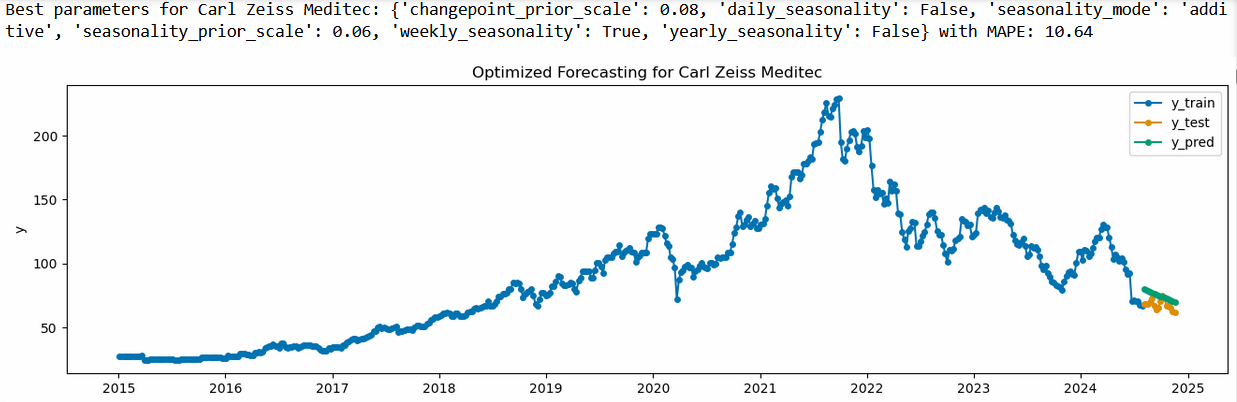
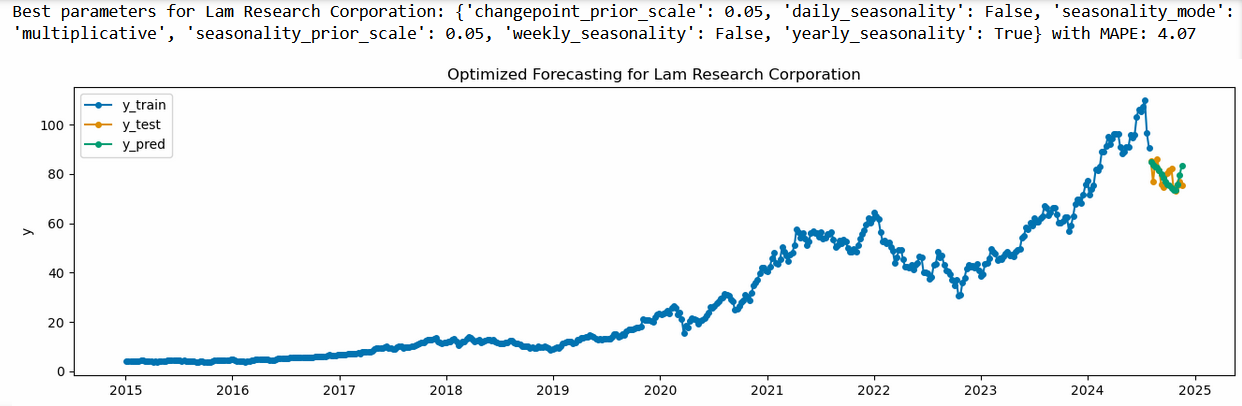
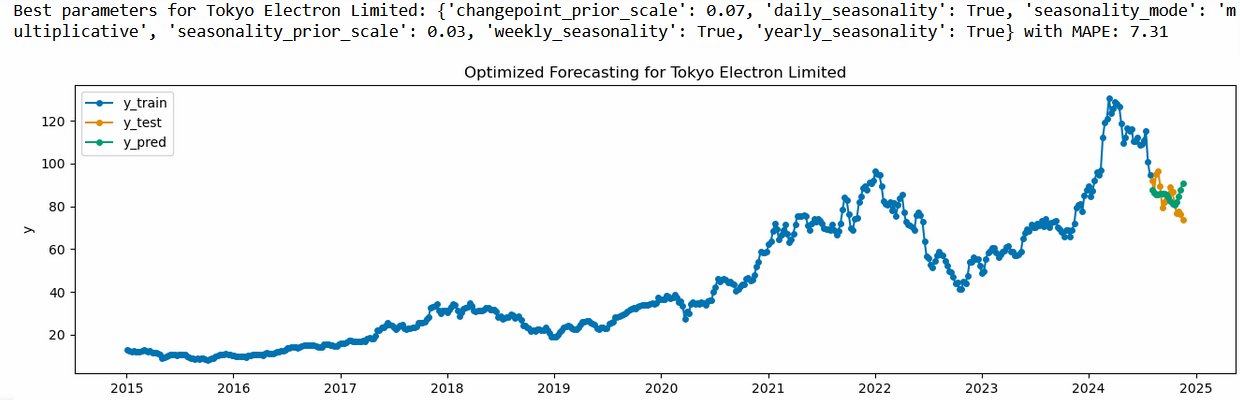
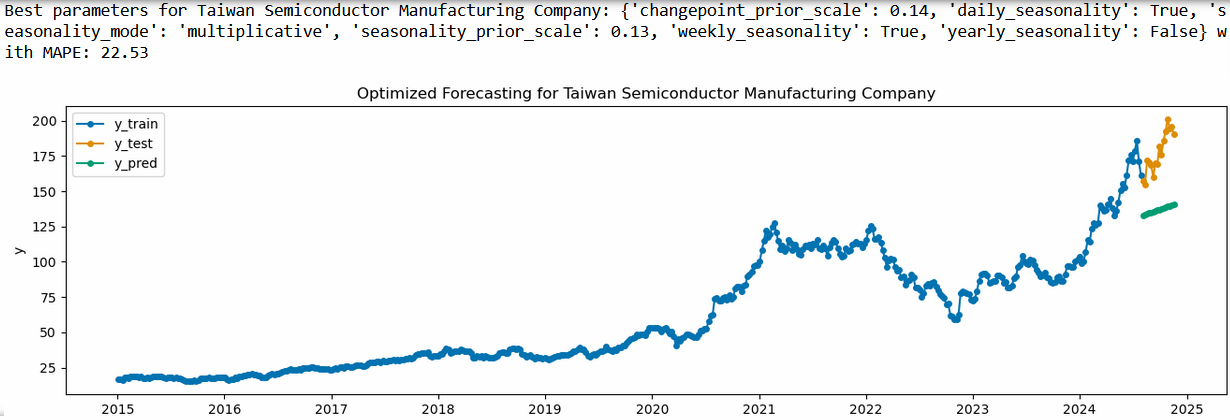
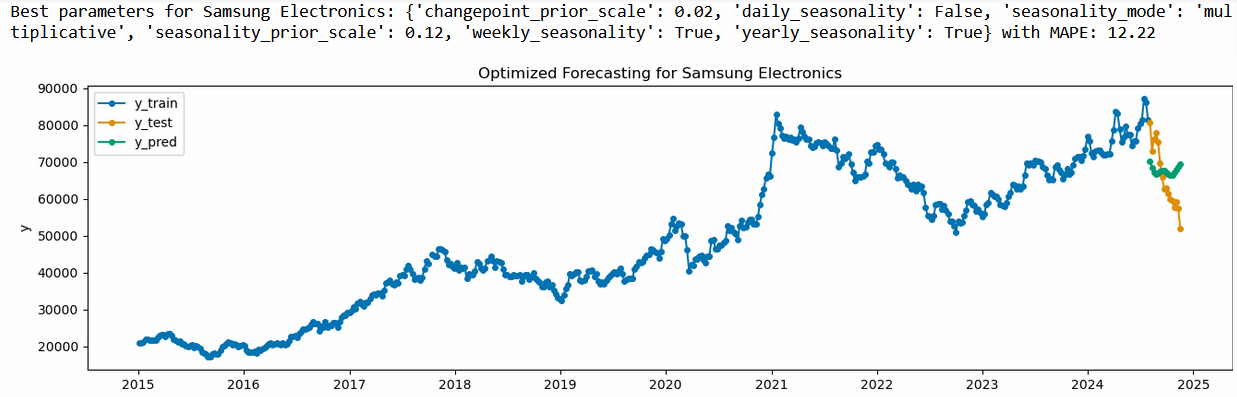
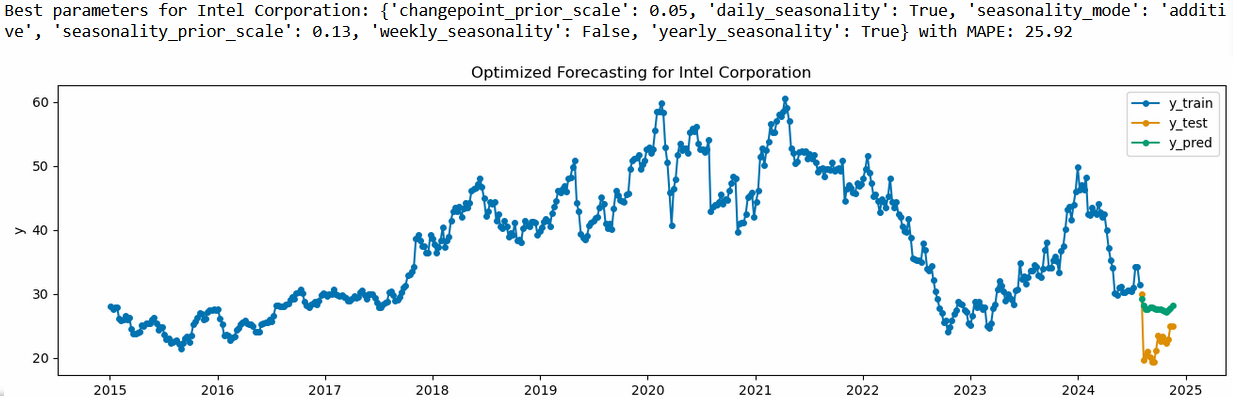

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [ ]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

# 3. Export the data

In [ ]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')